# 0.0 IMPORTS

In [87]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import inflection
import math
import datetime

from matplotlib          import pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL                 import Image
from tabulate            import tabulate
from scipy               import stats  as ss

## 0.1 Helper Funcitons

In [88]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

## 0.2 Loading Data

In [89]:
df_sales_raw = pd.read_csv('data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/raw/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [90]:
df_raw.sample()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
544211    877          6  2014-03-01   6019        791     1      0   

       StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
544211            0              0         a          c              29190.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
544211                        NaN                       NaN       0   

        Promo2SinceWeek  Promo2SinceYear PromoInterval  
544211              NaN              NaN           NaN

# 1.0 DATA DESCRIPTION

In [91]:
df1 = df_raw.copy()
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [92]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [93]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of Cols: {}' .format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [94]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [95]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [96]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                                if math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                             if x ['month_map'] in x ['promo_interval'].split(',') else 0, axis=1)

In [97]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [98]:
df1.sample(5)

store  day_of_week       date  sales  customers  open  promo  \
541262    158            1 2014-03-03   9005        517     1      1   
319611     18            5 2014-10-03      0          0     0      1   
15752     143            5 2015-07-17   7168        630     1      1   
833653    419            5 2013-06-14   4744        787     1      0   
244268    484            2 2014-12-23  16855       1528     1      0   

       state_holiday  school_holiday store_type assortment  \
541262             0               0          d          c   
319611             a               0          d          c   
15752              0               0          d          a   
833653             0               0          c          a   
244268             0               1          a          c   

        competition_distance  competition_open_since_month  \
541262               11840.0                           3.0   
319611               13840.0                           6.0   
15752                 2930.0                          12.0   
833653                1620.0                           9.0   
244268               14300.0                           3.0   

        competition_open_since_year  promo2  promo2_since_week  \
541262                       2014.0       1               31.0   
319611                       2010.0       1               14.0   
15752                        2002.0       0               29.0   
833653                       2009.0       0               24.0   
244268                       2011.0       0               52.0   

        promo2_since_year   promo_interval month_map  is_promo  
541262             2009.0  Feb,May,Aug,Nov       Mar         0  
319611             2012.0  Jan,Apr,Jul,Oct       Oct         1  
15752              2015.0                0       Jul         0  
833653             2013.0                0       Jun         0  
244268             2014.0                0       Dec         0

In [99]:
df1.sample(5).T

493713               396592  \
store                                         554                  390   
day_of_week                                     2                    7   
date                          2014-04-15 00:00:00  2014-07-13 00:00:00   
sales                                        6281                    0   
customers                                     733                    0   
open                                            1                    0   
promo                                           1                    0   
state_holiday                                   0                    0   
school_holiday                                  0                    0   
store_type                                      c                    a   
assortment                                      c                    c   
competition_distance                       1200.0               1600.0   
competition_open_since_month                  4.0                  4.0   
competition_open_since_year                2014.0               2009.0   
promo2                                          0                    0   
promo2_since_week                            16.0                 28.0   
promo2_since_year                          2014.0               2014.0   
promo_interval                                  0                    0   
month_map                                     Apr                  Jul   
is_promo                                        0                    0   

                                           714840               361797  \
store                                         911                  157   
day_of_week                                     7                    2   
date                          2013-09-29 00:00:00  2014-08-19 00:00:00   
sales                                           0                12717   
customers                                       0                 1173   
open                                            0                    1   
promo                                           0                    1   
state_holiday                                   0                    0   
school_holiday                                  0                    1   
store_type                                      a                    a   
assortment                                      c                    c   
competition_distance                      16490.0               2950.0   
competition_open_since_month                  9.0                 10.0   
competition_open_since_year                2013.0               2004.0   
promo2                                          0                    0   
promo2_since_week                            39.0                 34.0   
promo2_since_year                          2013.0               2014.0   
promo_interval                                  0                    0   
month_map                                    Sept                  Aug   
is_promo                                        0                    0   

                                           588885  
store                                         951  
day_of_week                                     1  
date                          2014-01-20 00:00:00  
sales                                       10385  
customers                                     894  
open                                            1  
promo                                           1  
state_holiday                                   0  
school_holiday                                  0  
store_type                                      d  
assortment                                      c  
competition_distance                        710.0  
competition_open_since_month                  1.0  
competition_open_since_year                2014.0  
promo2                                          1  
promo2_since_week                            40.0  
promo2_since_year                          2011.0

## 1.6 Change Types

In [100]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [101]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [102]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [103]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes     min       max     range         mean  \
0                          store     1.0    1115.0    1114.0   558.429727   
1                    day_of_week     1.0       7.0       6.0     3.998341   
2                          sales     0.0   41551.0   41551.0  5773.818972   
3                      customers     0.0    7388.0    7388.0   633.145946   
4                           open     0.0       1.0       1.0     0.830107   
5                          promo     0.0       1.0       1.0     0.381515   
6                 school_holiday     0.0       1.0       1.0     0.178647   
7           competition_distance    20.0  200000.0  199980.0  5935.442677   
8   competition_open_since_month     1.0      12.0      11.0     6.786849   
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840   
10                        promo2     0.0       1.0       1.0     0.500564   
11             promo2_since_week     1.0      52.0      51.0    23.619033   
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297   
13                      is_promo     0.0       1.0       1.0     0.171835   

    median           std       skew    kurtosis  
0    558.0    321.908493  -0.000955   -1.200524  
1      4.0      1.997390   0.001593   -1.246873  
2   5744.0   3849.924283   0.641460    1.778375  
3    609.0    464.411506   1.598650    7.091773  
4      1.0      0.375539  -1.758045    1.090723  
5      0.0      0.485758   0.487838   -1.762018  
6      0.0      0.383056   1.677842    0.815154  
7   2330.0  12547.646829  10.242344  147.789712  
8      7.0      3.311085  -0.042076   -1.232607  
9   2012.0      5.515591  -7.235657  124.071304  
10     1.0      0.500000  -0.002255   -1.999999  
11    22.0     14.310057   0.178723   -1.184046  
12  2013.0      1.662657  -0.784436   -0.210075  
13     0.0      0.377237   1.739838    1.027039

/tmp/ipykernel_24315/1849127075.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales']);


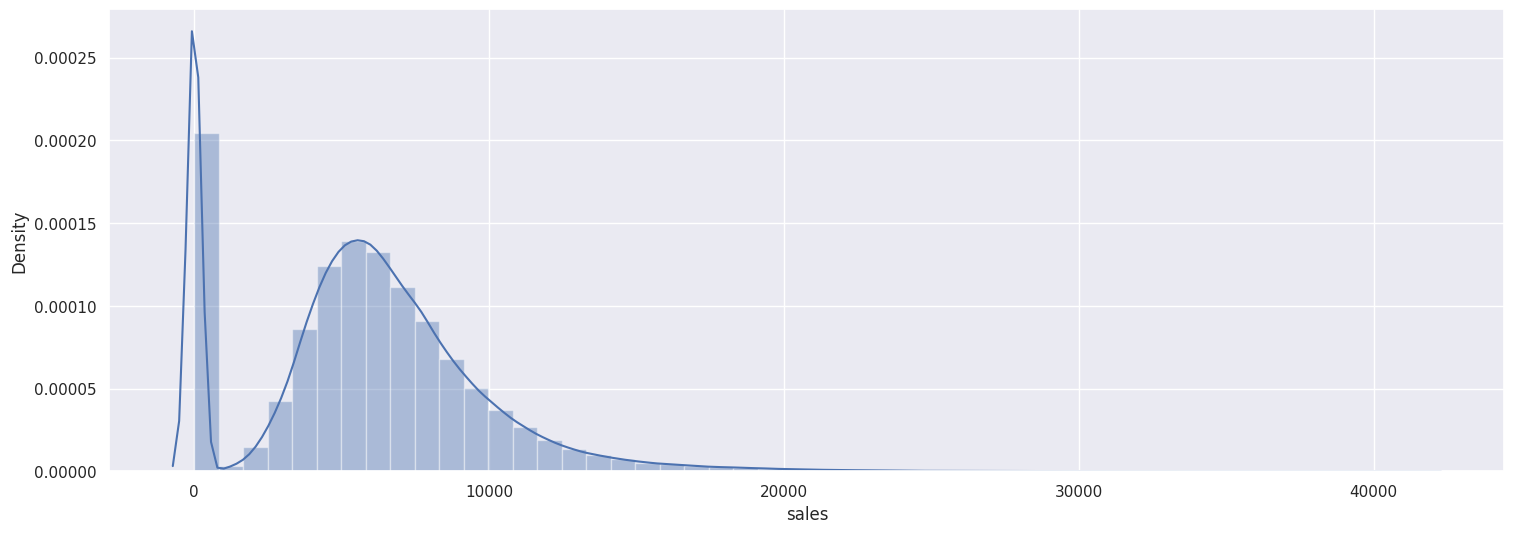

In [104]:
# Ajuste de tamanho para os gráficos criados
sns.set(rc={'figure.figsize':(18, 6)})

sns.distplot(df1['sales']);

### 1.7.2 Categorical Attributes

In [105]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

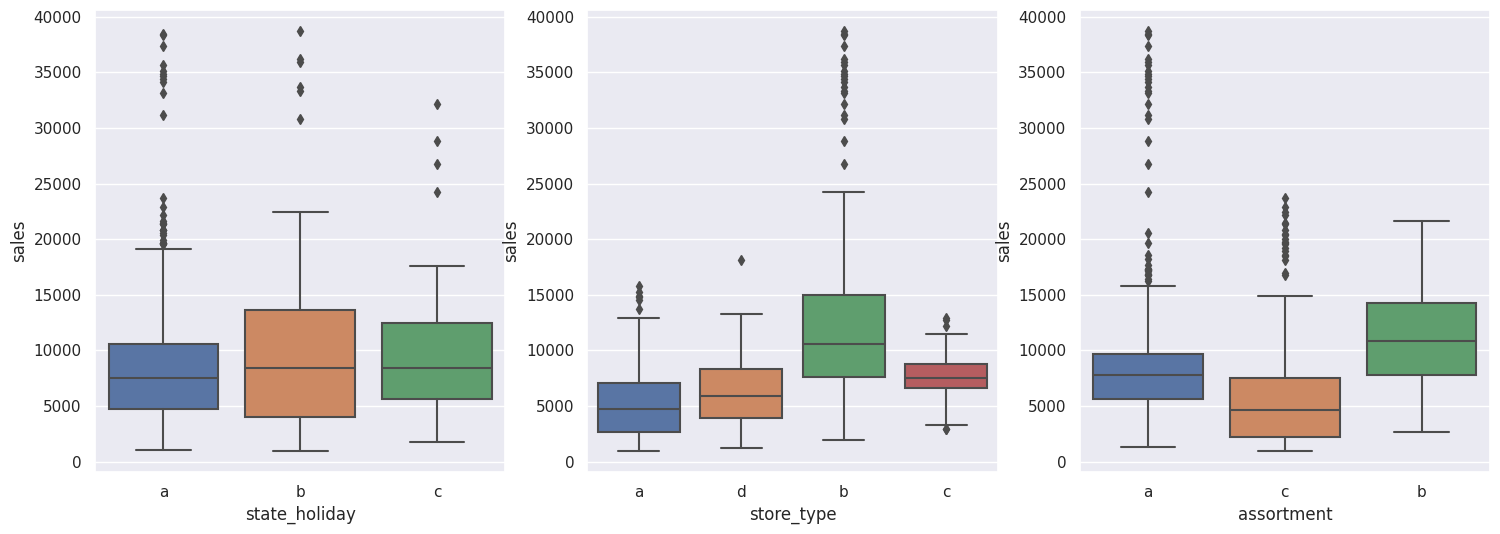

In [106]:
# Ajuste de tamanho para os gráficos criados
sns.set(rc={'figure.figsize':(18, 6)})


aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux)

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux)

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux)

# 2.0 FEATURE ENGINEERING

In [107]:
df2 =df1.copy()

## 2.1 Mapa Mental de Hipóteses

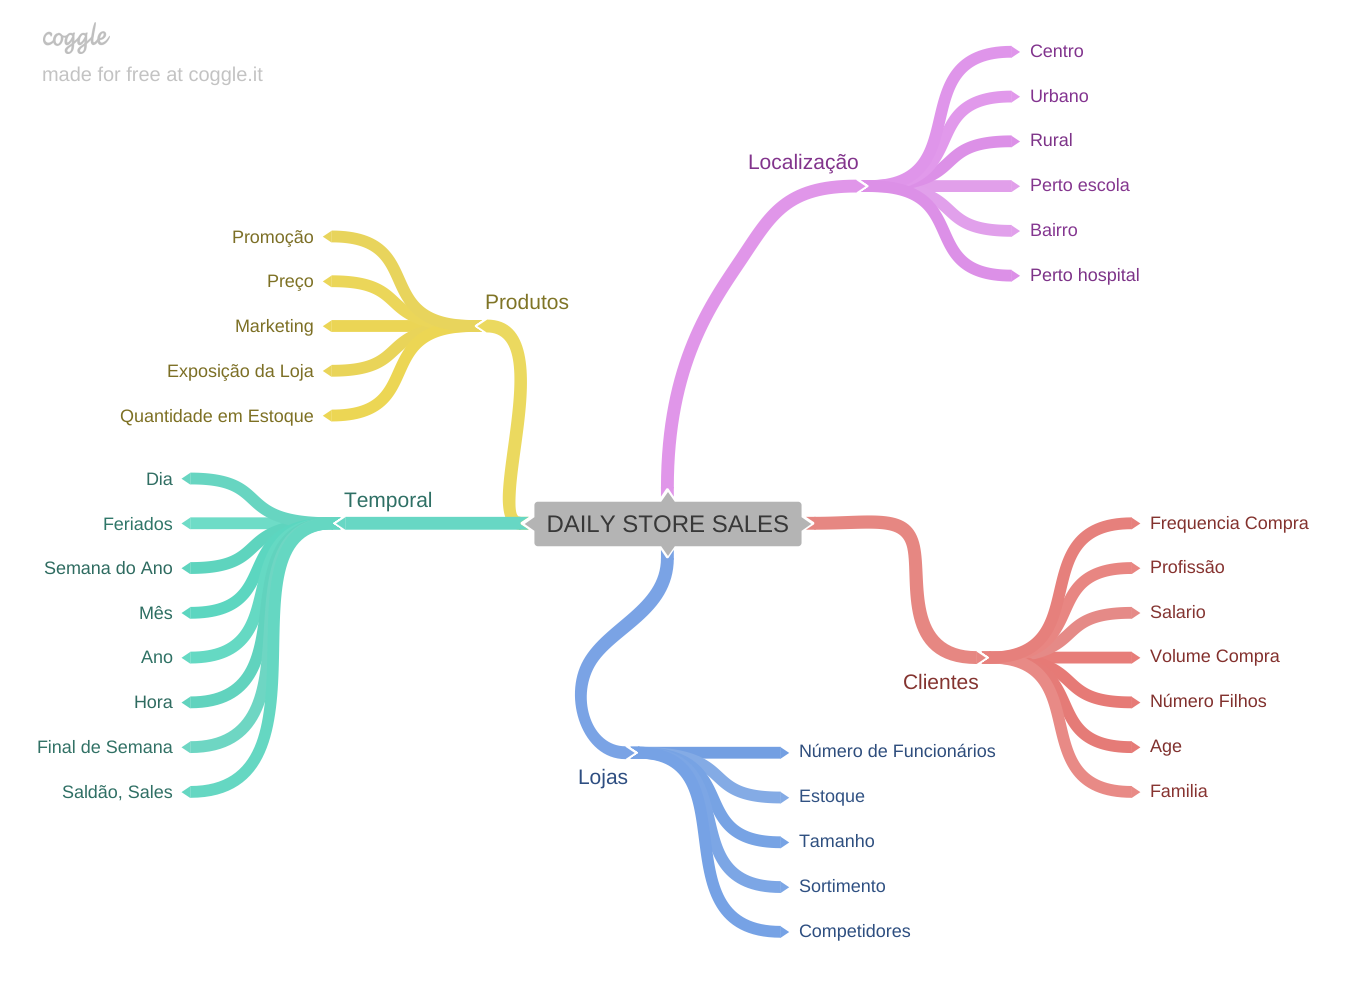

In [108]:
img = Image.open('img/mindmap.png')
width = img.width // 200
height = img.height // 200
img_resized = img.resize((width, height))
img

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Lojas

**1.** Lojas com número maior de funcionários deveriam vender mais. 

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontes maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depoiss do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depoiss do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [109]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competiton_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competiton_since'])/30).apply(lambda x: x.days).astype(int)
                                      
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [110]:
df2.head().T

0                    1  \
store                                           1                    2   
day_of_week                                     5                    5   
date                          2015-07-31 00:00:00  2015-07-31 00:00:00   
sales                                        5263                 6064   
customers                                     555                  625   
open                                            1                    1   
promo                                           1                    1   
state_holiday                         regular_day          regular_day   
school_holiday                                  1                    1   
store_type                                      c                    a   
assortment                                  basic                basic   
competition_distance                       1270.0                570.0   
competition_open_since_month                    9                   11   
competition_open_since_year                  2008                 2007   
promo2                                          0                    1   
promo2_since_week                              31                   13   
promo2_since_year                            2015                 2010   
promo_interval                                  0      Jan,Apr,Jul,Oct   
month_map                                     Jul                  Jul   
is_promo                                        0                    1   
year                                         2015                 2015   
month                                           7                    7   
day                                            31                   31   
week_of_year                                   31                   31   
year_week                                 2015-30              2015-30   
competiton_since              2008-09-01 00:00:00  2007-11-01 00:00:00   
competition_time_month                         84                   94   
promo_since                   2015-07-27 00:00:00  2010-03-22 00:00:00   
promo_time_week                                 0                  279   

                                                2                    3  \
store                                           3                    4   
day_of_week                                     5                    5   
date                          2015-07-31 00:00:00  2015-07-31 00:00:00   
sales                                        8314                13995   
customers                                     821                 1498   
open                                            1                    1   
promo                                           1                    1   
state_holiday                         regular_day          regular_day   
school_holiday                                  1                    1   
store_type                                      a                    c   
assortment                                  basic             extended   
competition_distance                      14130.0                620.0   
competition_open_since_month                   12                    9   
competition_open_since_year                  2006                 2009   
promo2                                          1                    0   
promo2_since_week                              14                   31   
promo2_since_year                            2011                 2015   
promo_interval                    Jan,Apr,Jul,Oct                    0   
month_map                                     Jul                  Jul   
is_promo                                        1                    0   
year                                         2015                 2015   
month                                           7                    7   
day                                            31                   31   
week_of_year                                   31  

# 3.0 Filtragem de Variáveis

In [111]:
df3 = df2.copy()
df3.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  \
0      1            5 2015-07-31   5263        555     1      1   regular_day   
1      2            5 2015-07-31   6064        625     1      1   regular_day   
2      3            5 2015-07-31   8314        821     1      1   regular_day   
3      4            5 2015-07-31  13995       1498     1      1   regular_day   
4      5            5 2015-07-31   4822        559     1      1   regular_day   

   school_holiday store_type  ... is_promo  year  month  day  week_of_year  \
0               1          c  ...        0  2015      7   31            31   
1               1          a  ...        1  2015      7   31            31   
2               1          a  ...        1  2015      7   31            31   
3               1          c  ...        0  2015      7   31            31   
4               1          a  ...        0  2015      7   31            31   

   year_week  competiton_since competition_time_month promo_since  \
0    2015-30        2008-09-01                     84  2015-07-27   
1    2015-30        2007-11-01                     94  2010-03-22   
2    2015-30        2006-12-01                    105  2011-03-28   
3    2015-30        2009-09-01                     71  2015-07-27   
4    2015-30        2015-04-01                      4  2015-07-27   

   promo_time_week  
0                0  
1              279  
2              226  
3                0  
4                0  

[5 rows x 29 columns]

## 3.1 Filtragem das Linhas

In [112]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [113]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competiton_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória de Dados

In [114]:
df4 =df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

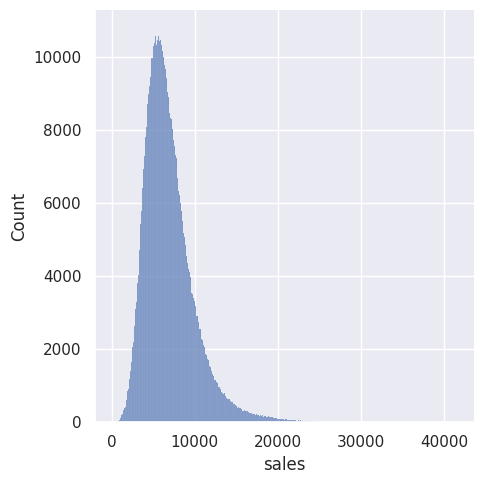

In [115]:
# Ajuste de tamanho para os gráficos criados
sns.set(rc={'figure.figsize':(60, 50)})
        
sns.displot(df4['sales'], kde=False)

### 4.1.2 Numerical Variable

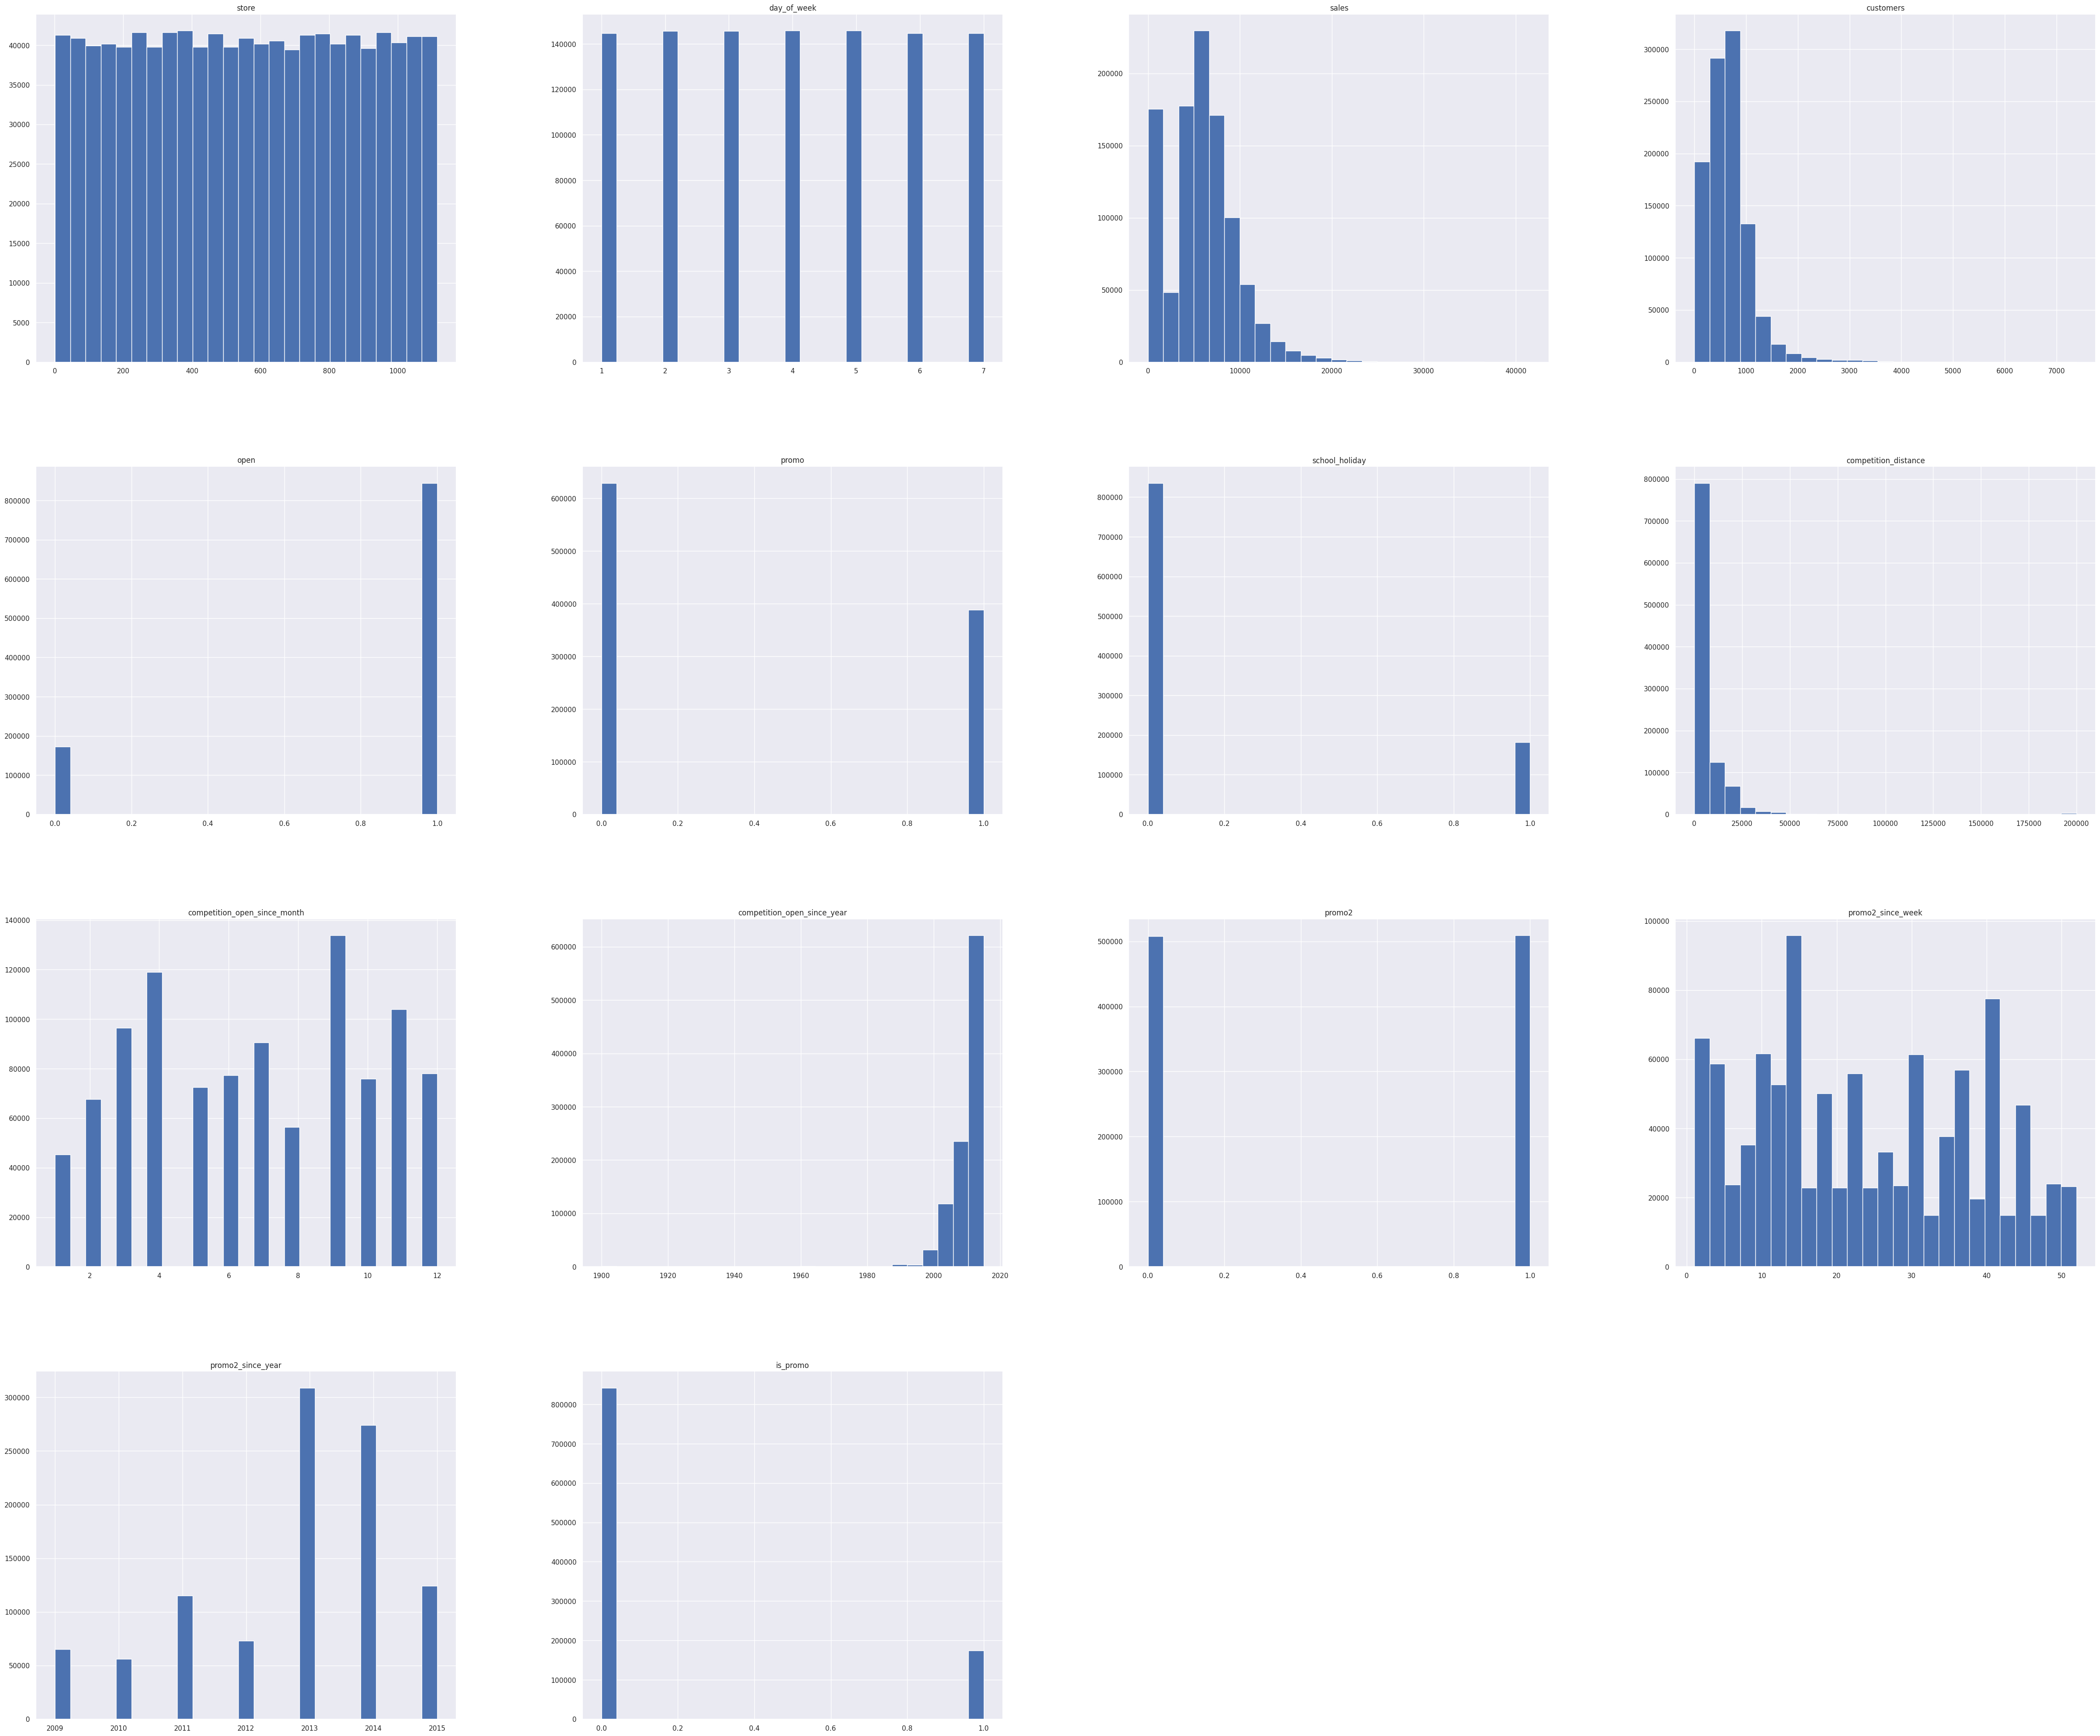

In [116]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [117]:
print(df4['state_holiday'].drop_duplicates())
print(df4['store_type'].drop_duplicates())
print(df4['assortment'].drop_duplicates())

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object
0     c
1     a
12    d
84    b
Name: store_type, dtype: object
0         basic
3      extended
258       extra
Name: assortment, dtype: object


<AxesSubplot: xlabel='sales', ylabel='Density'>

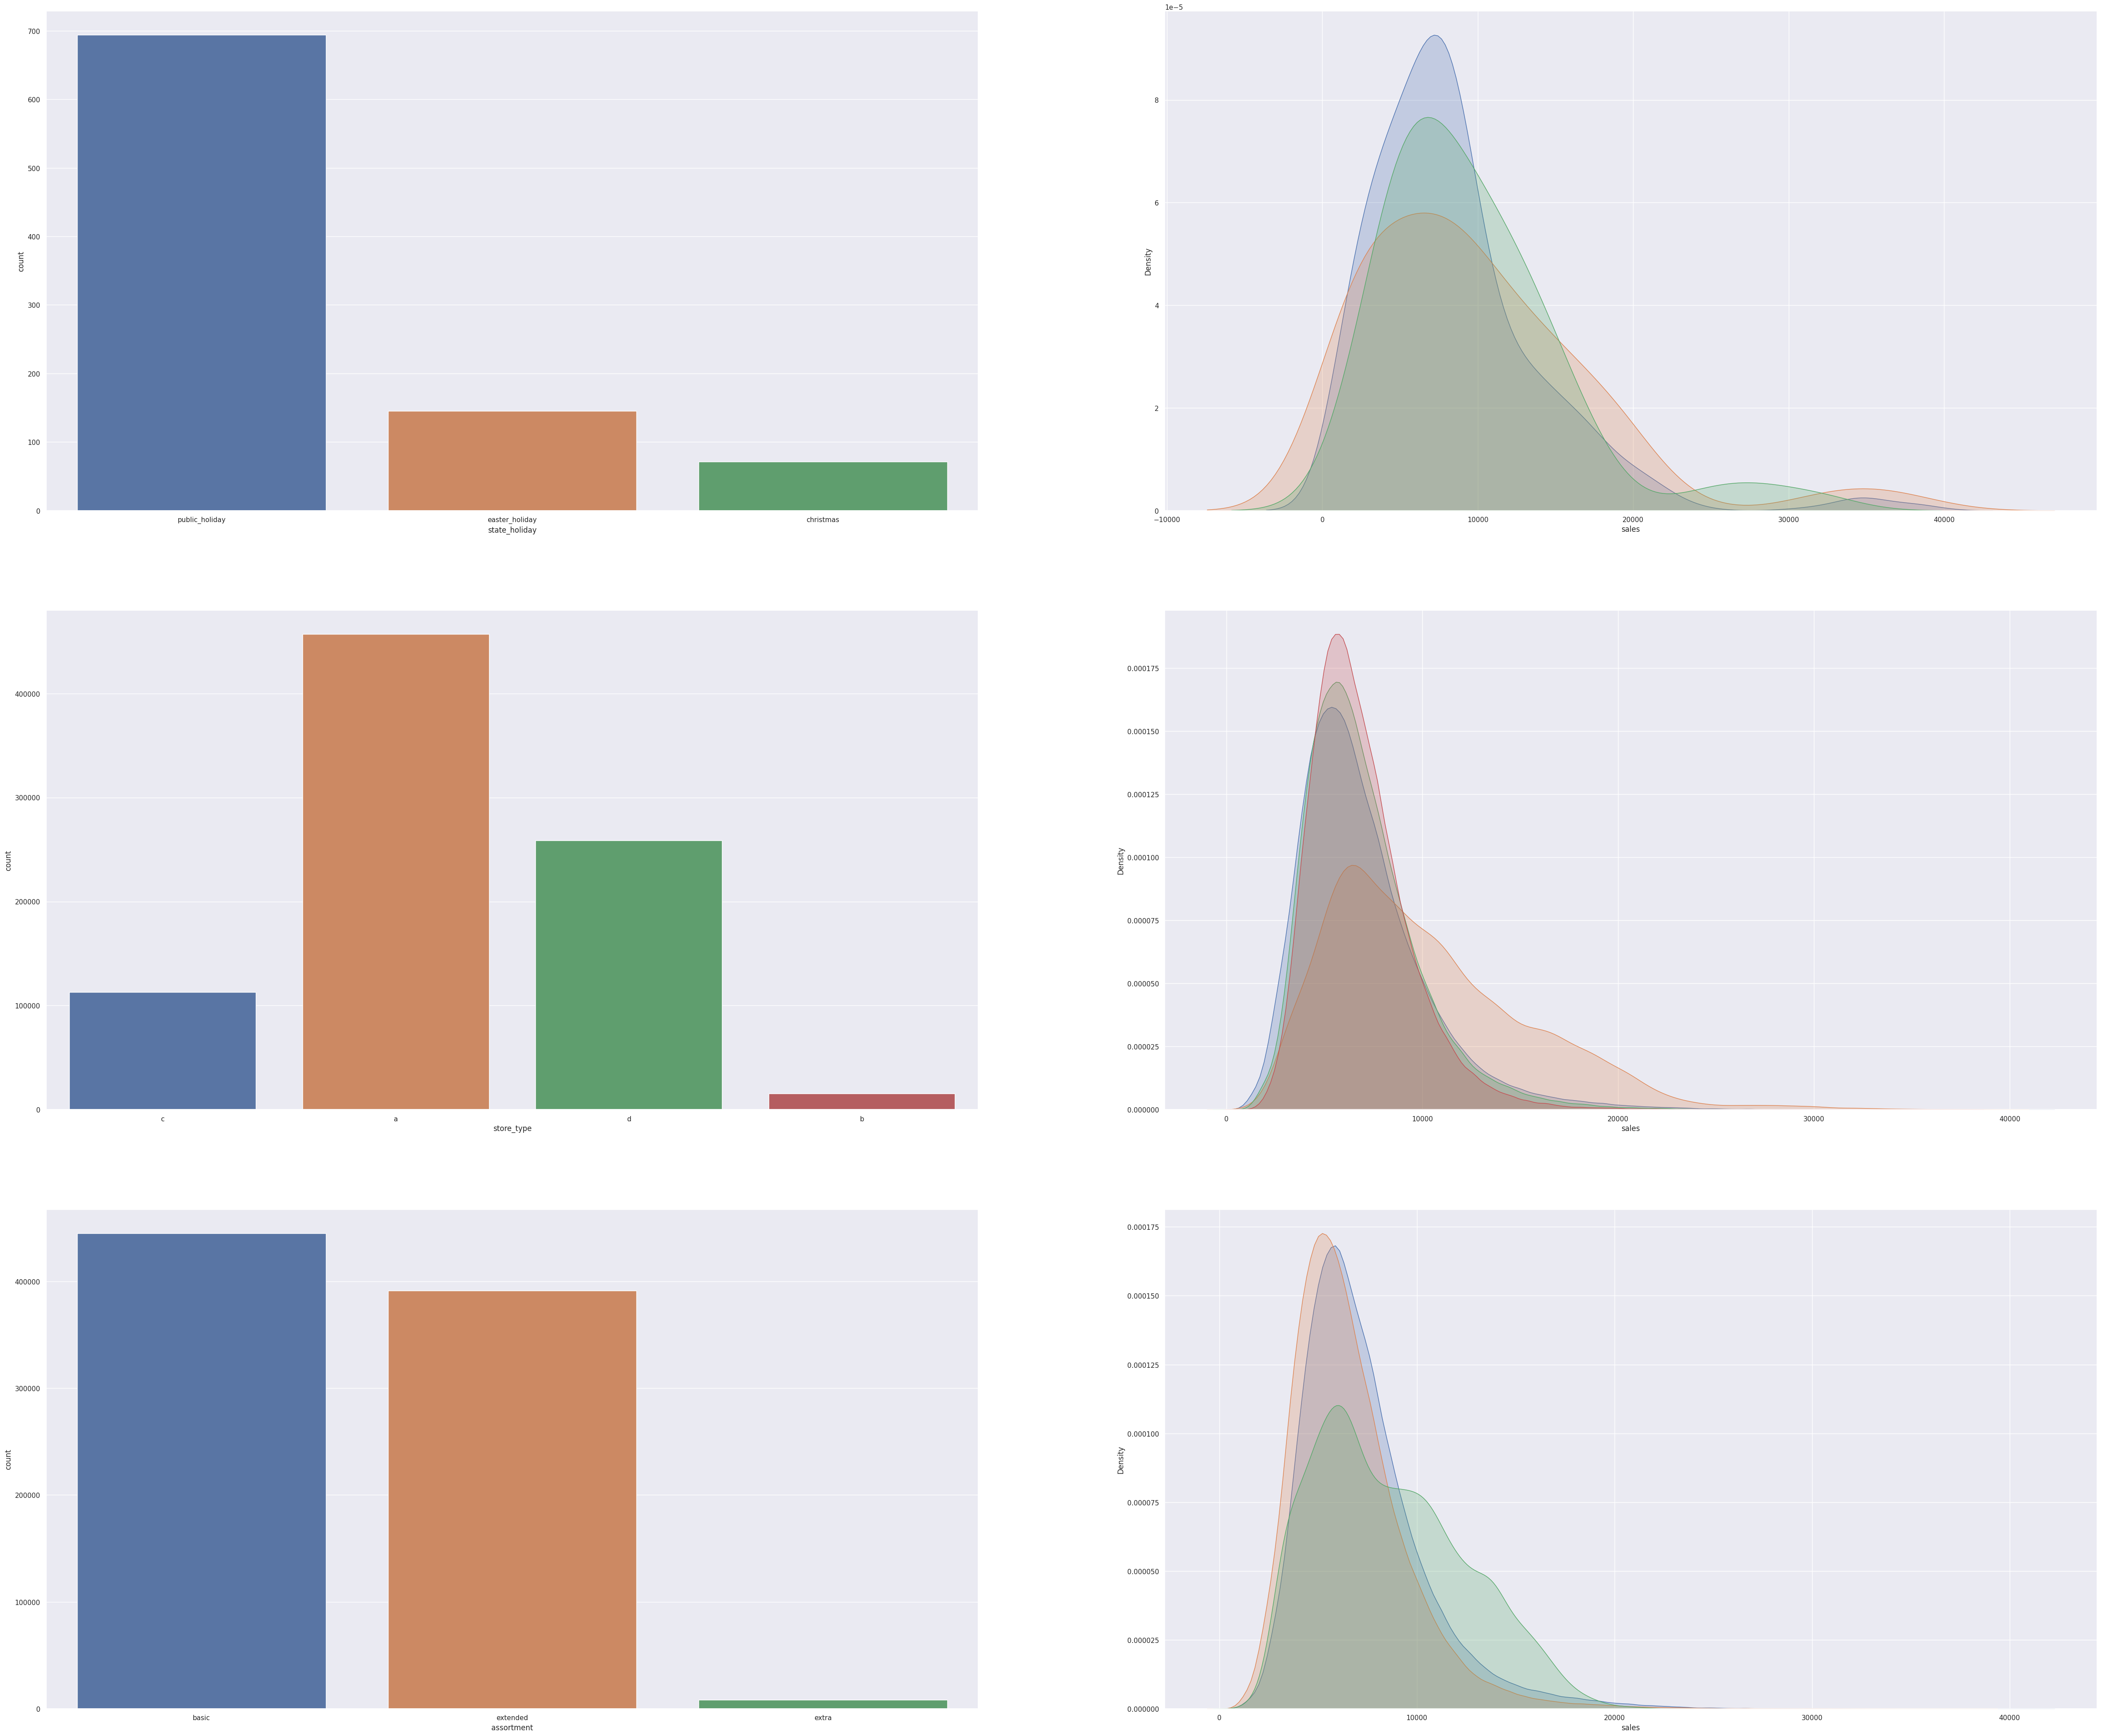

In [118]:
# state_holiday

plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )

# store_type

plt.subplot( 3, 2, 3 )
sns.countplot(x=df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment

plt.subplot( 3, 2, 5 )
sns.countplot(x=df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )

## 4.2 Análise Bivariada

### 4.2.1 Hipóteses

#### **H1** Lojas com maior sortimentos deveriam vender mais
**Falsa** - lojas com maior sortimento vendem menos!

<AxesSubplot: xlabel='year_week'>

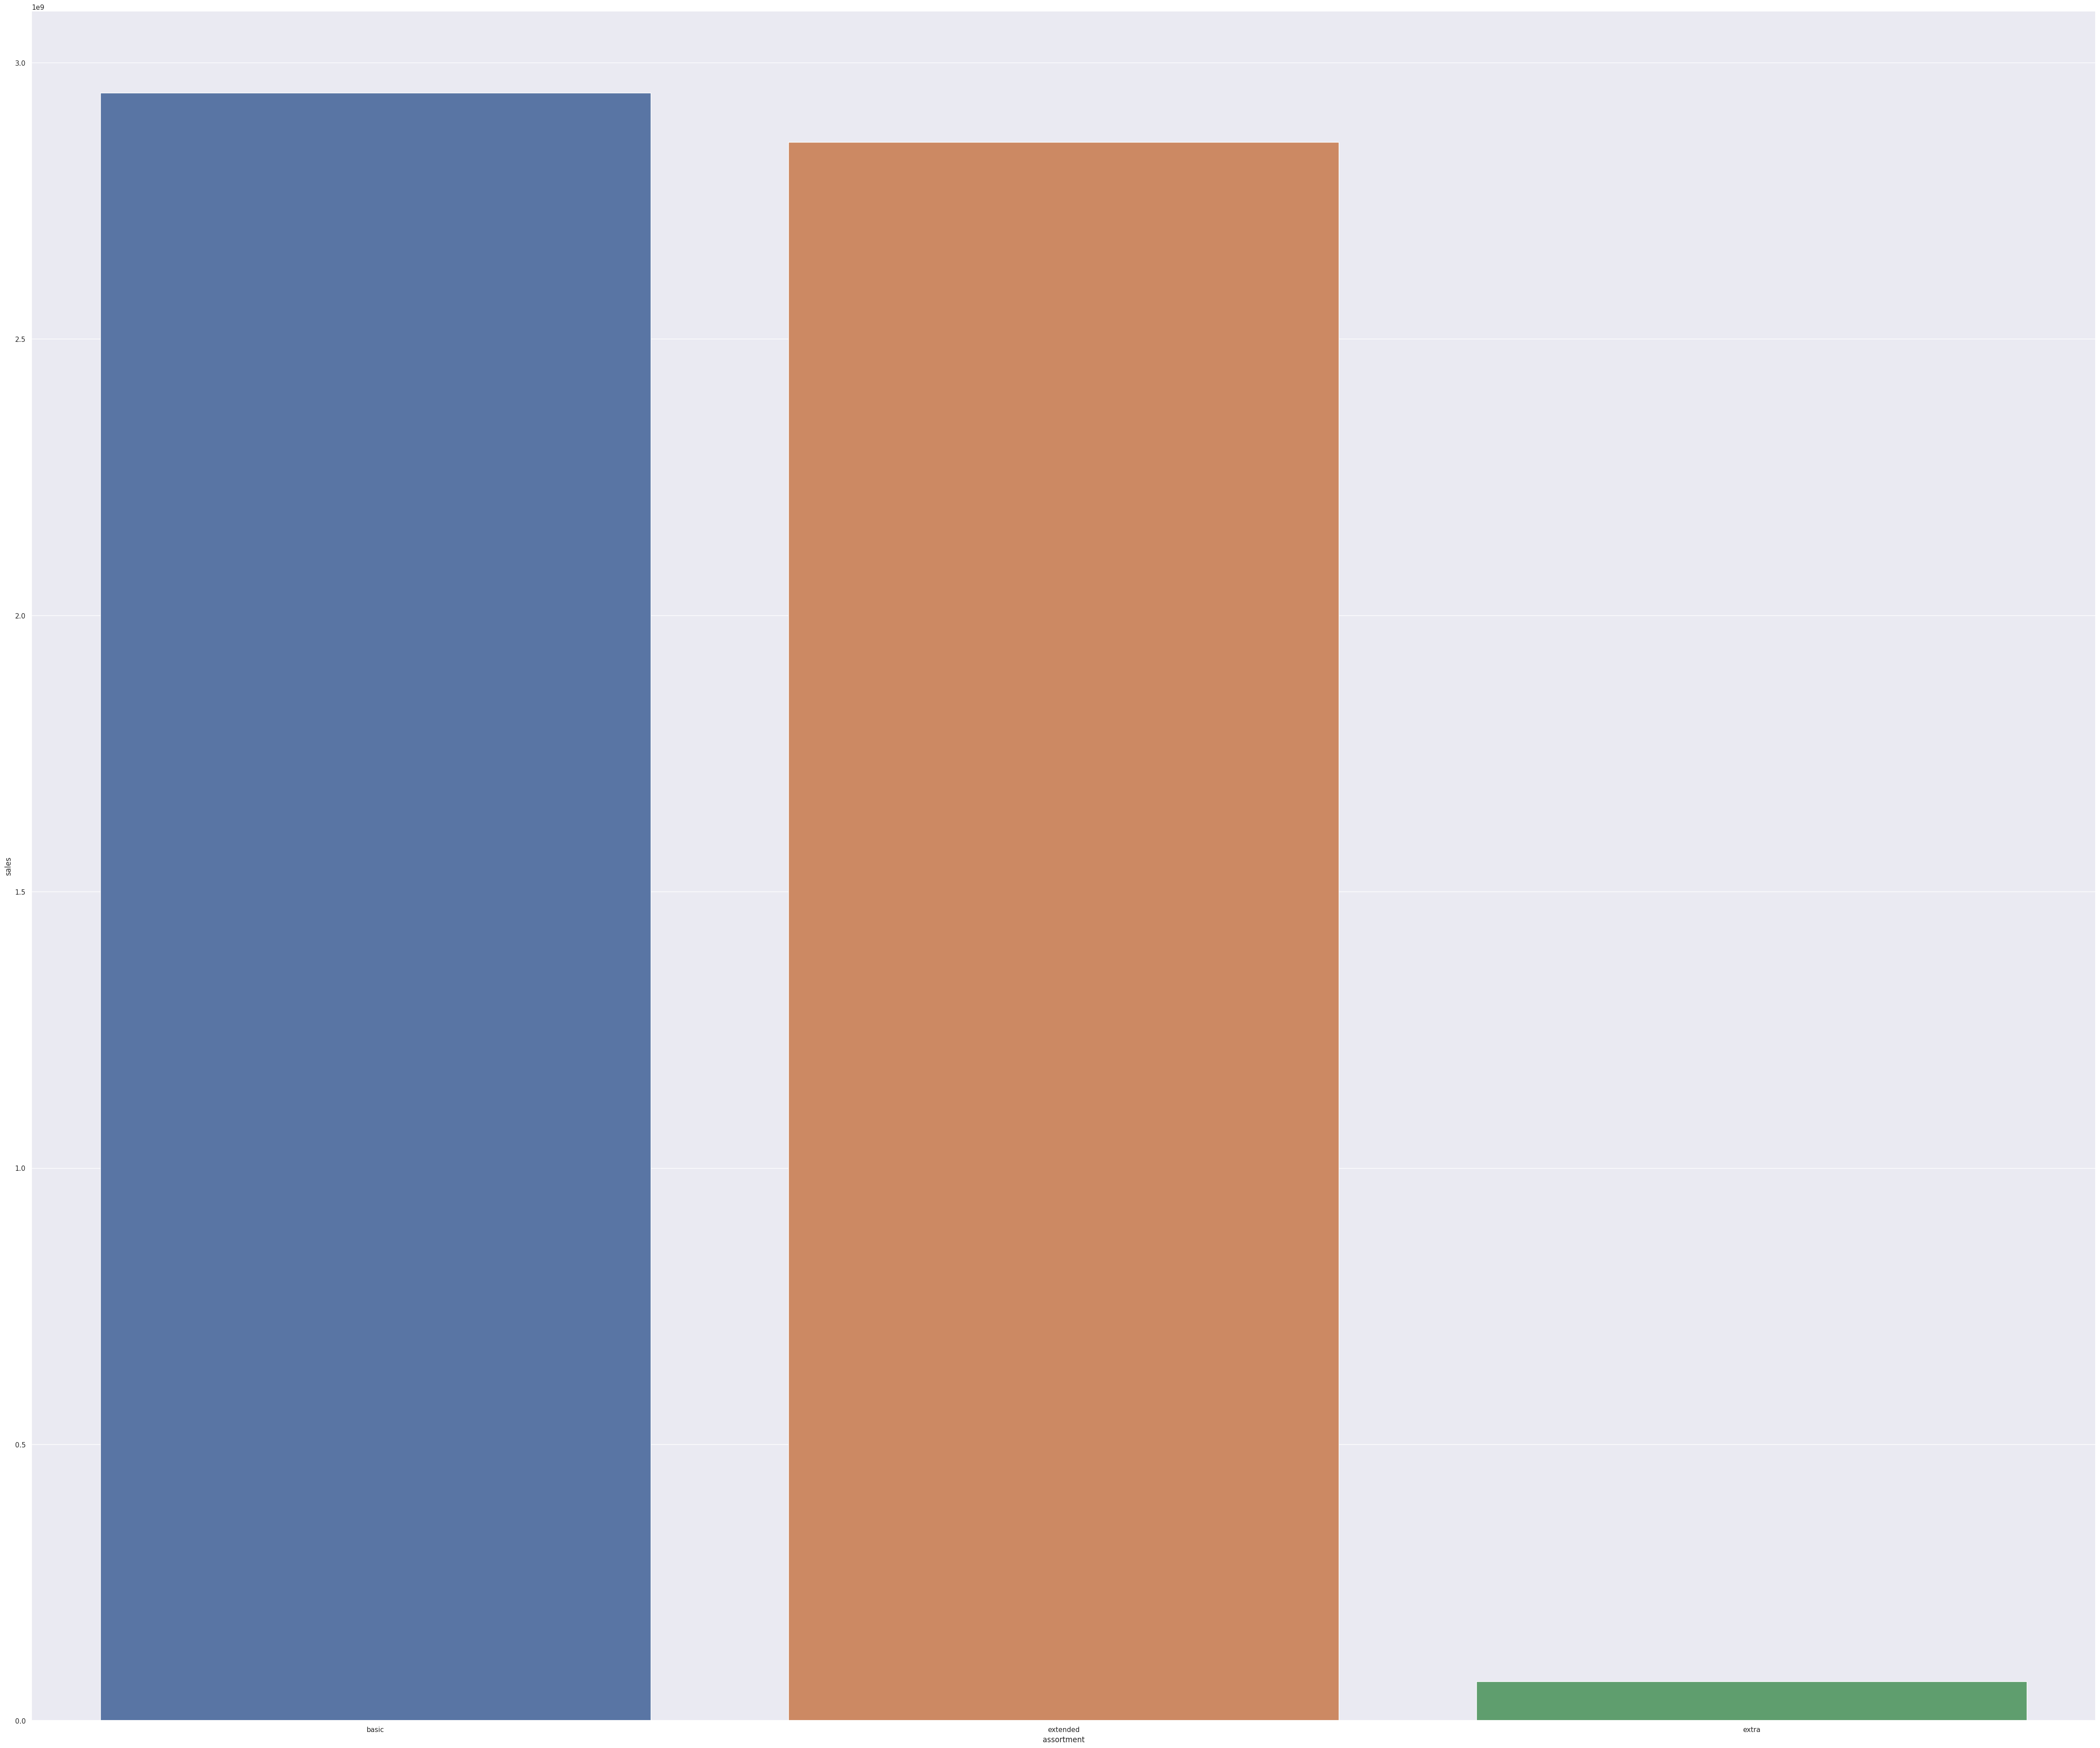

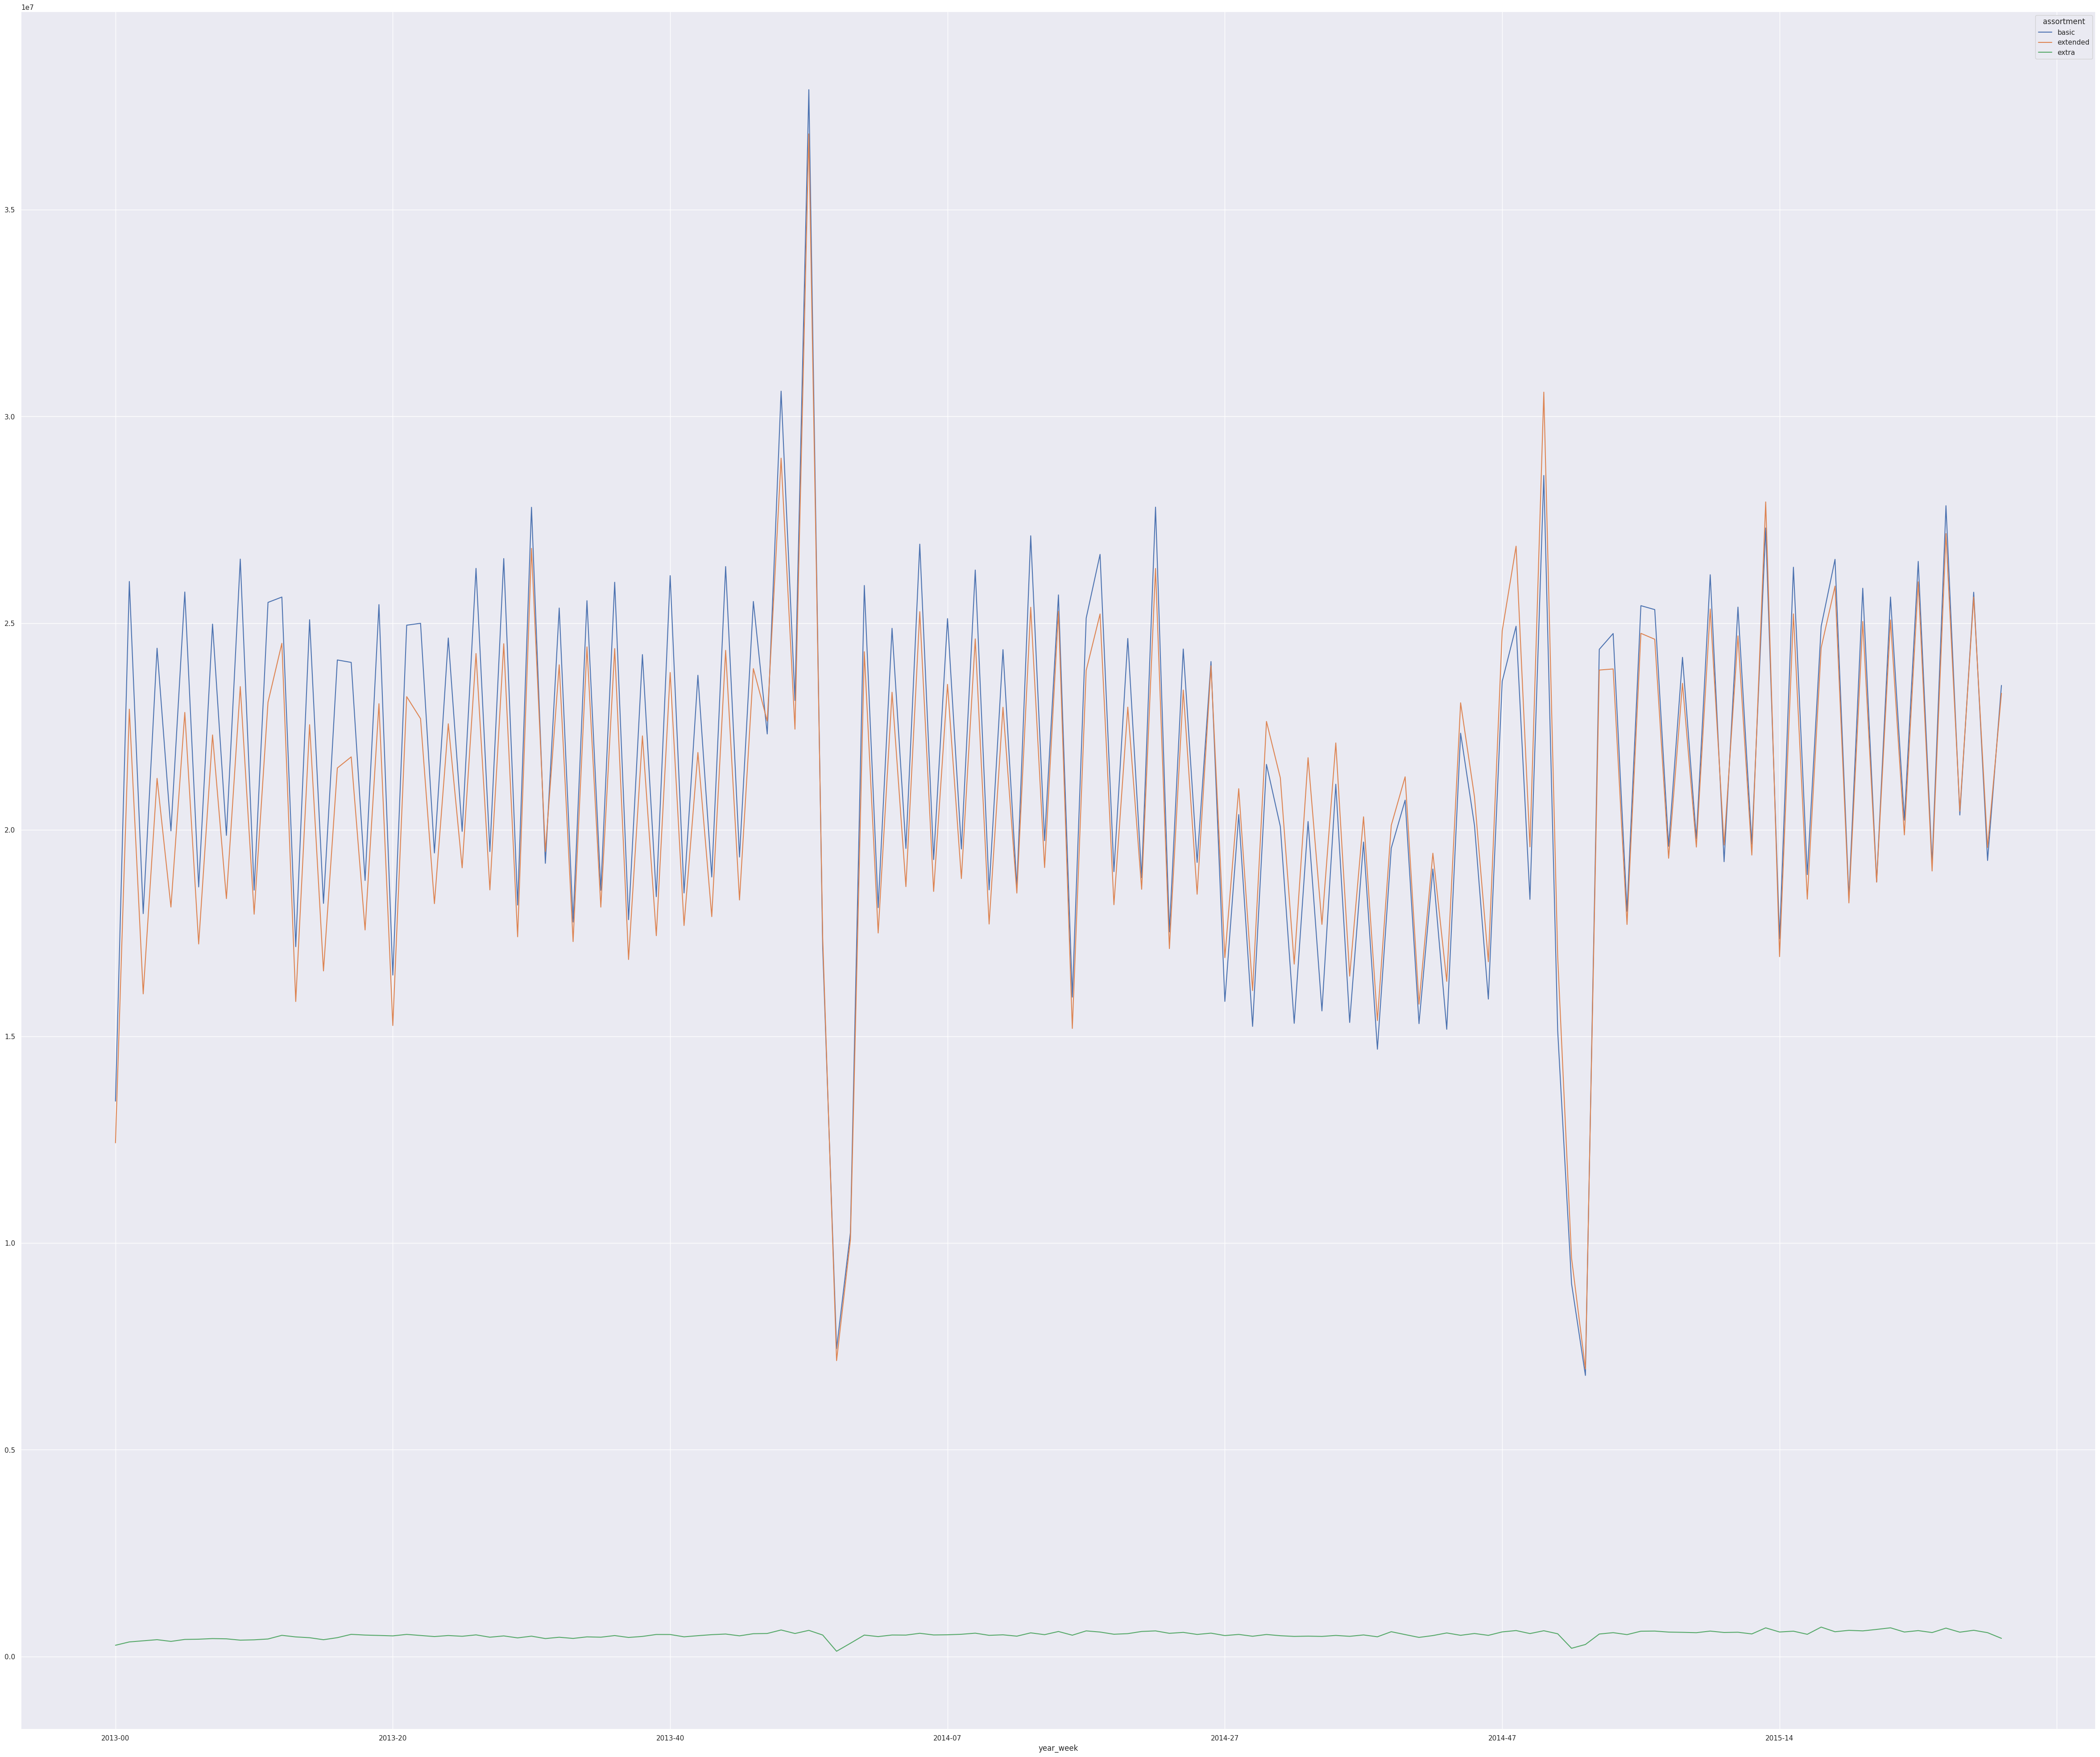

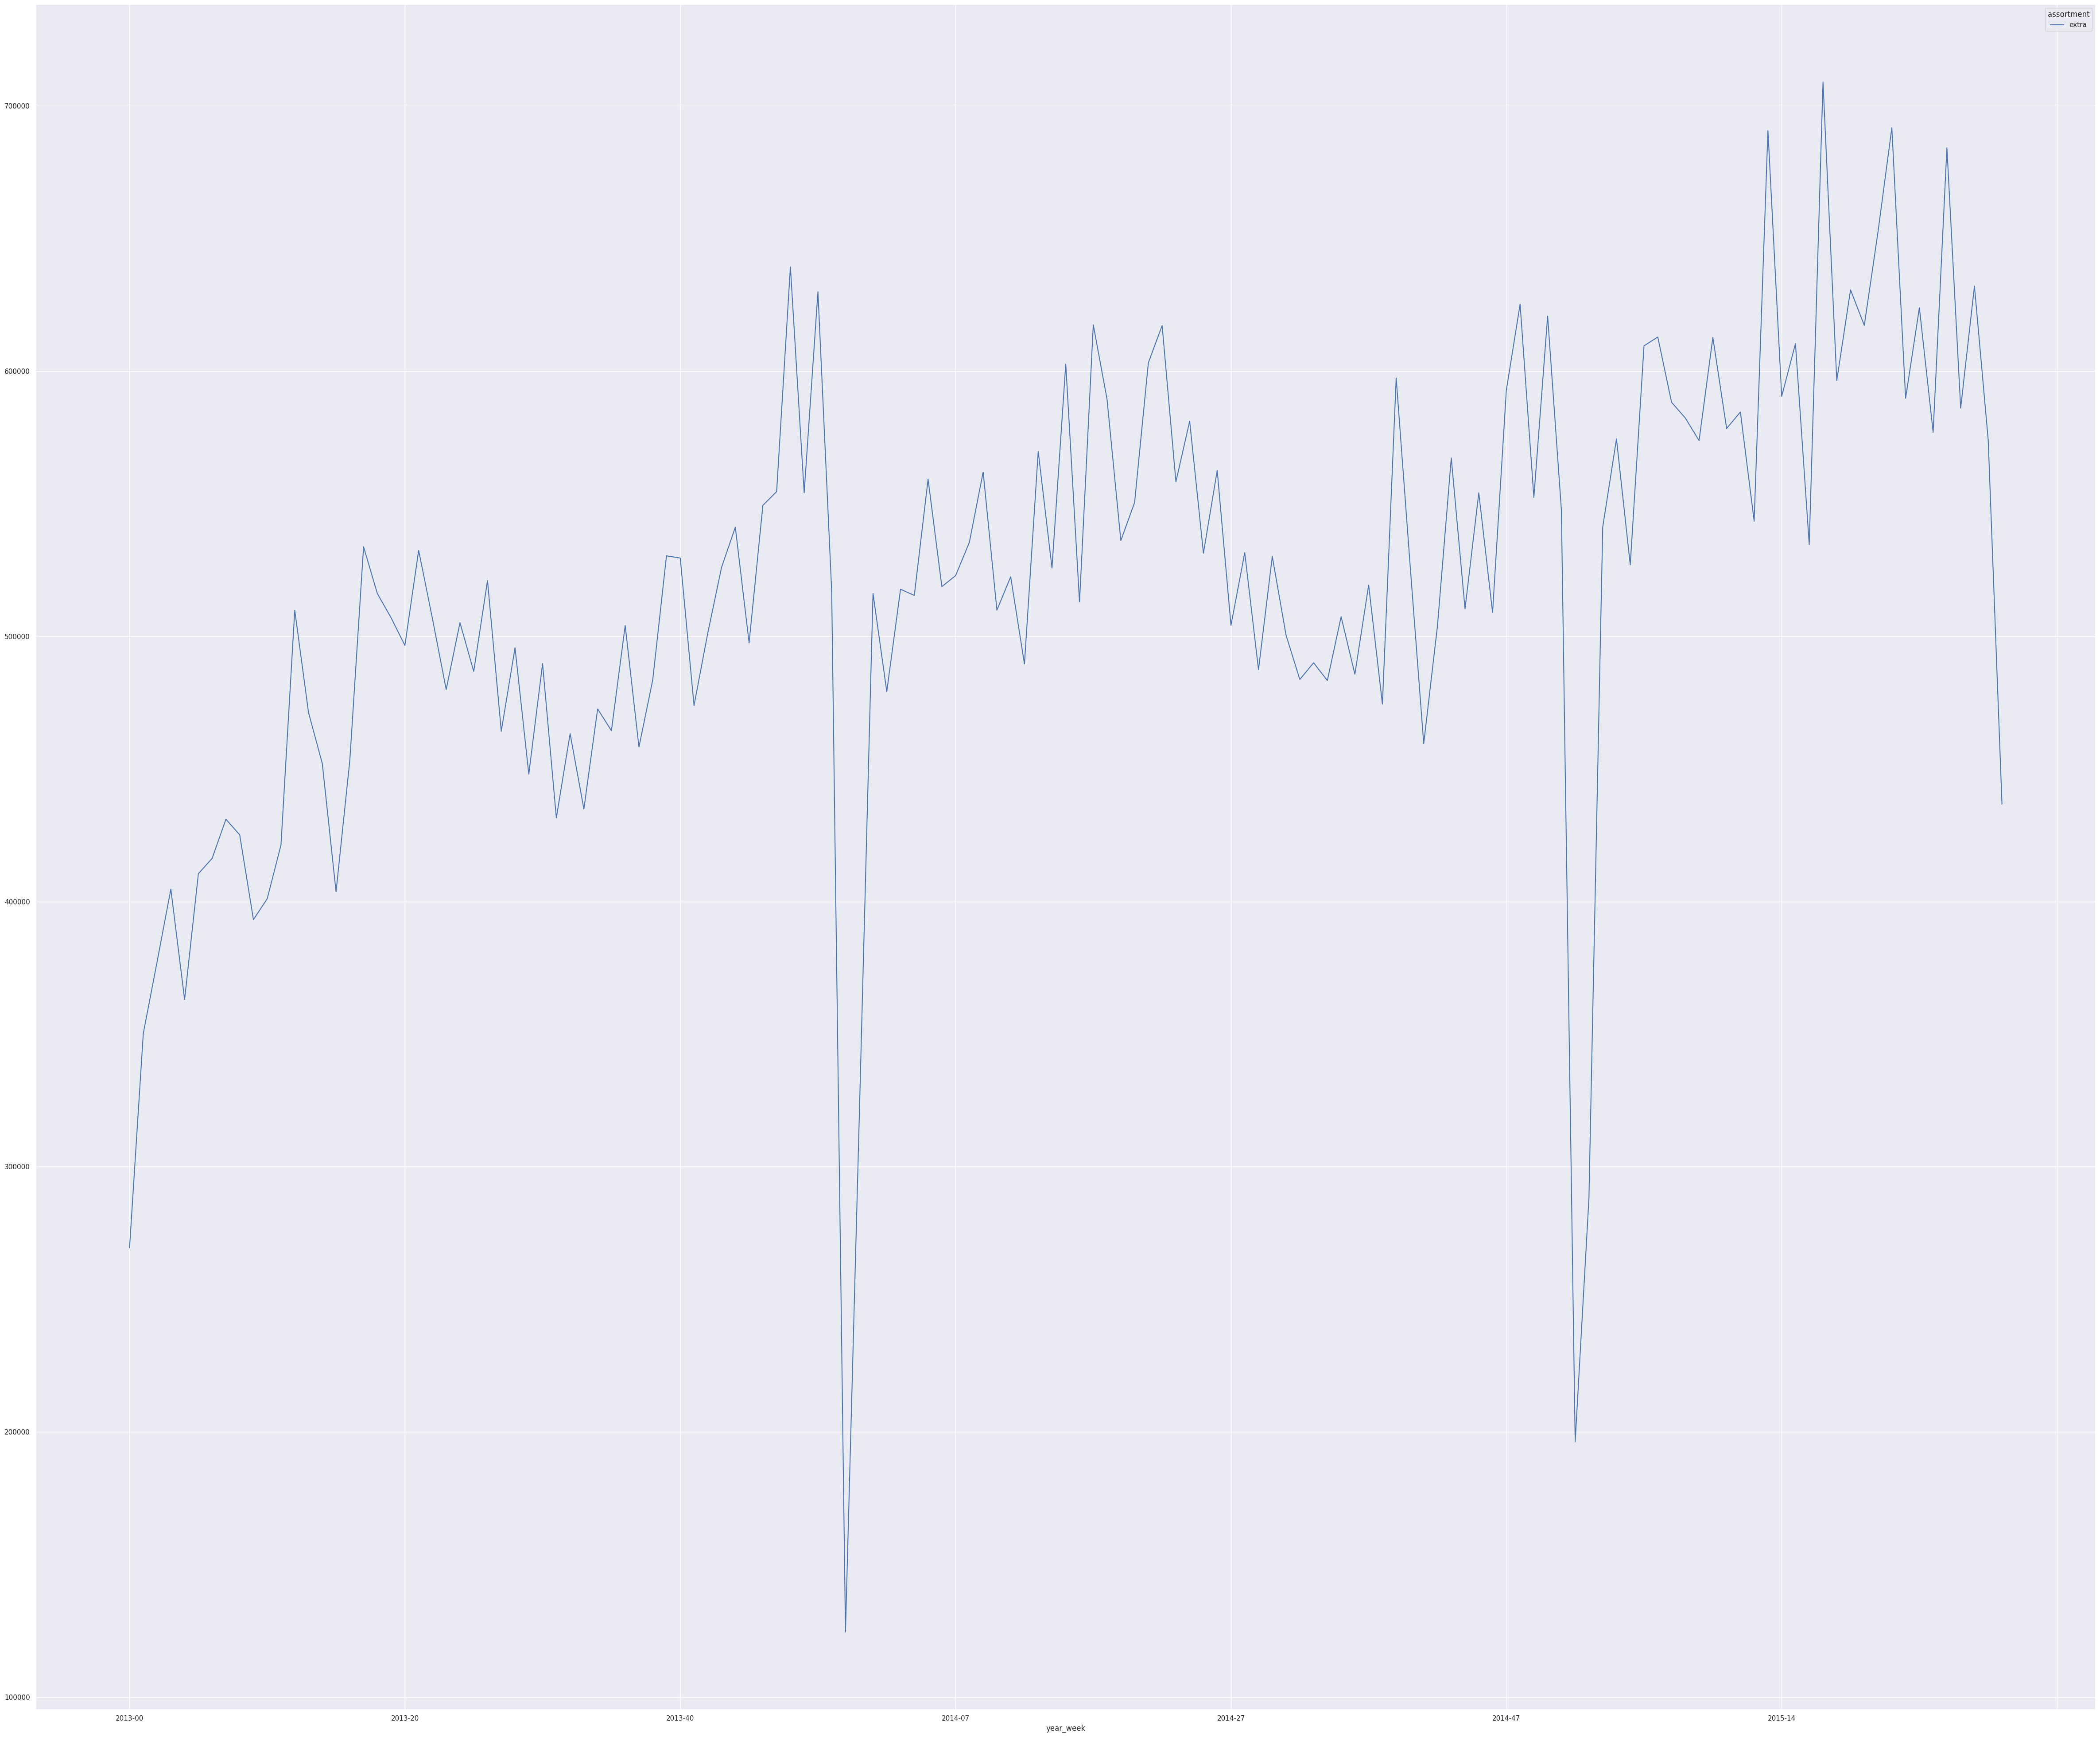

In [119]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
# aux1.head()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
# aux2.head()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### **H2** Lojas com competidores mais próximos deveriam vender menos.
**Falsa** - lojas com competidores mais próximos vendem mais.

/tmp/ipykernel_24315/2064171814.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap(aux1.corr(method='pearson'), annot=True);


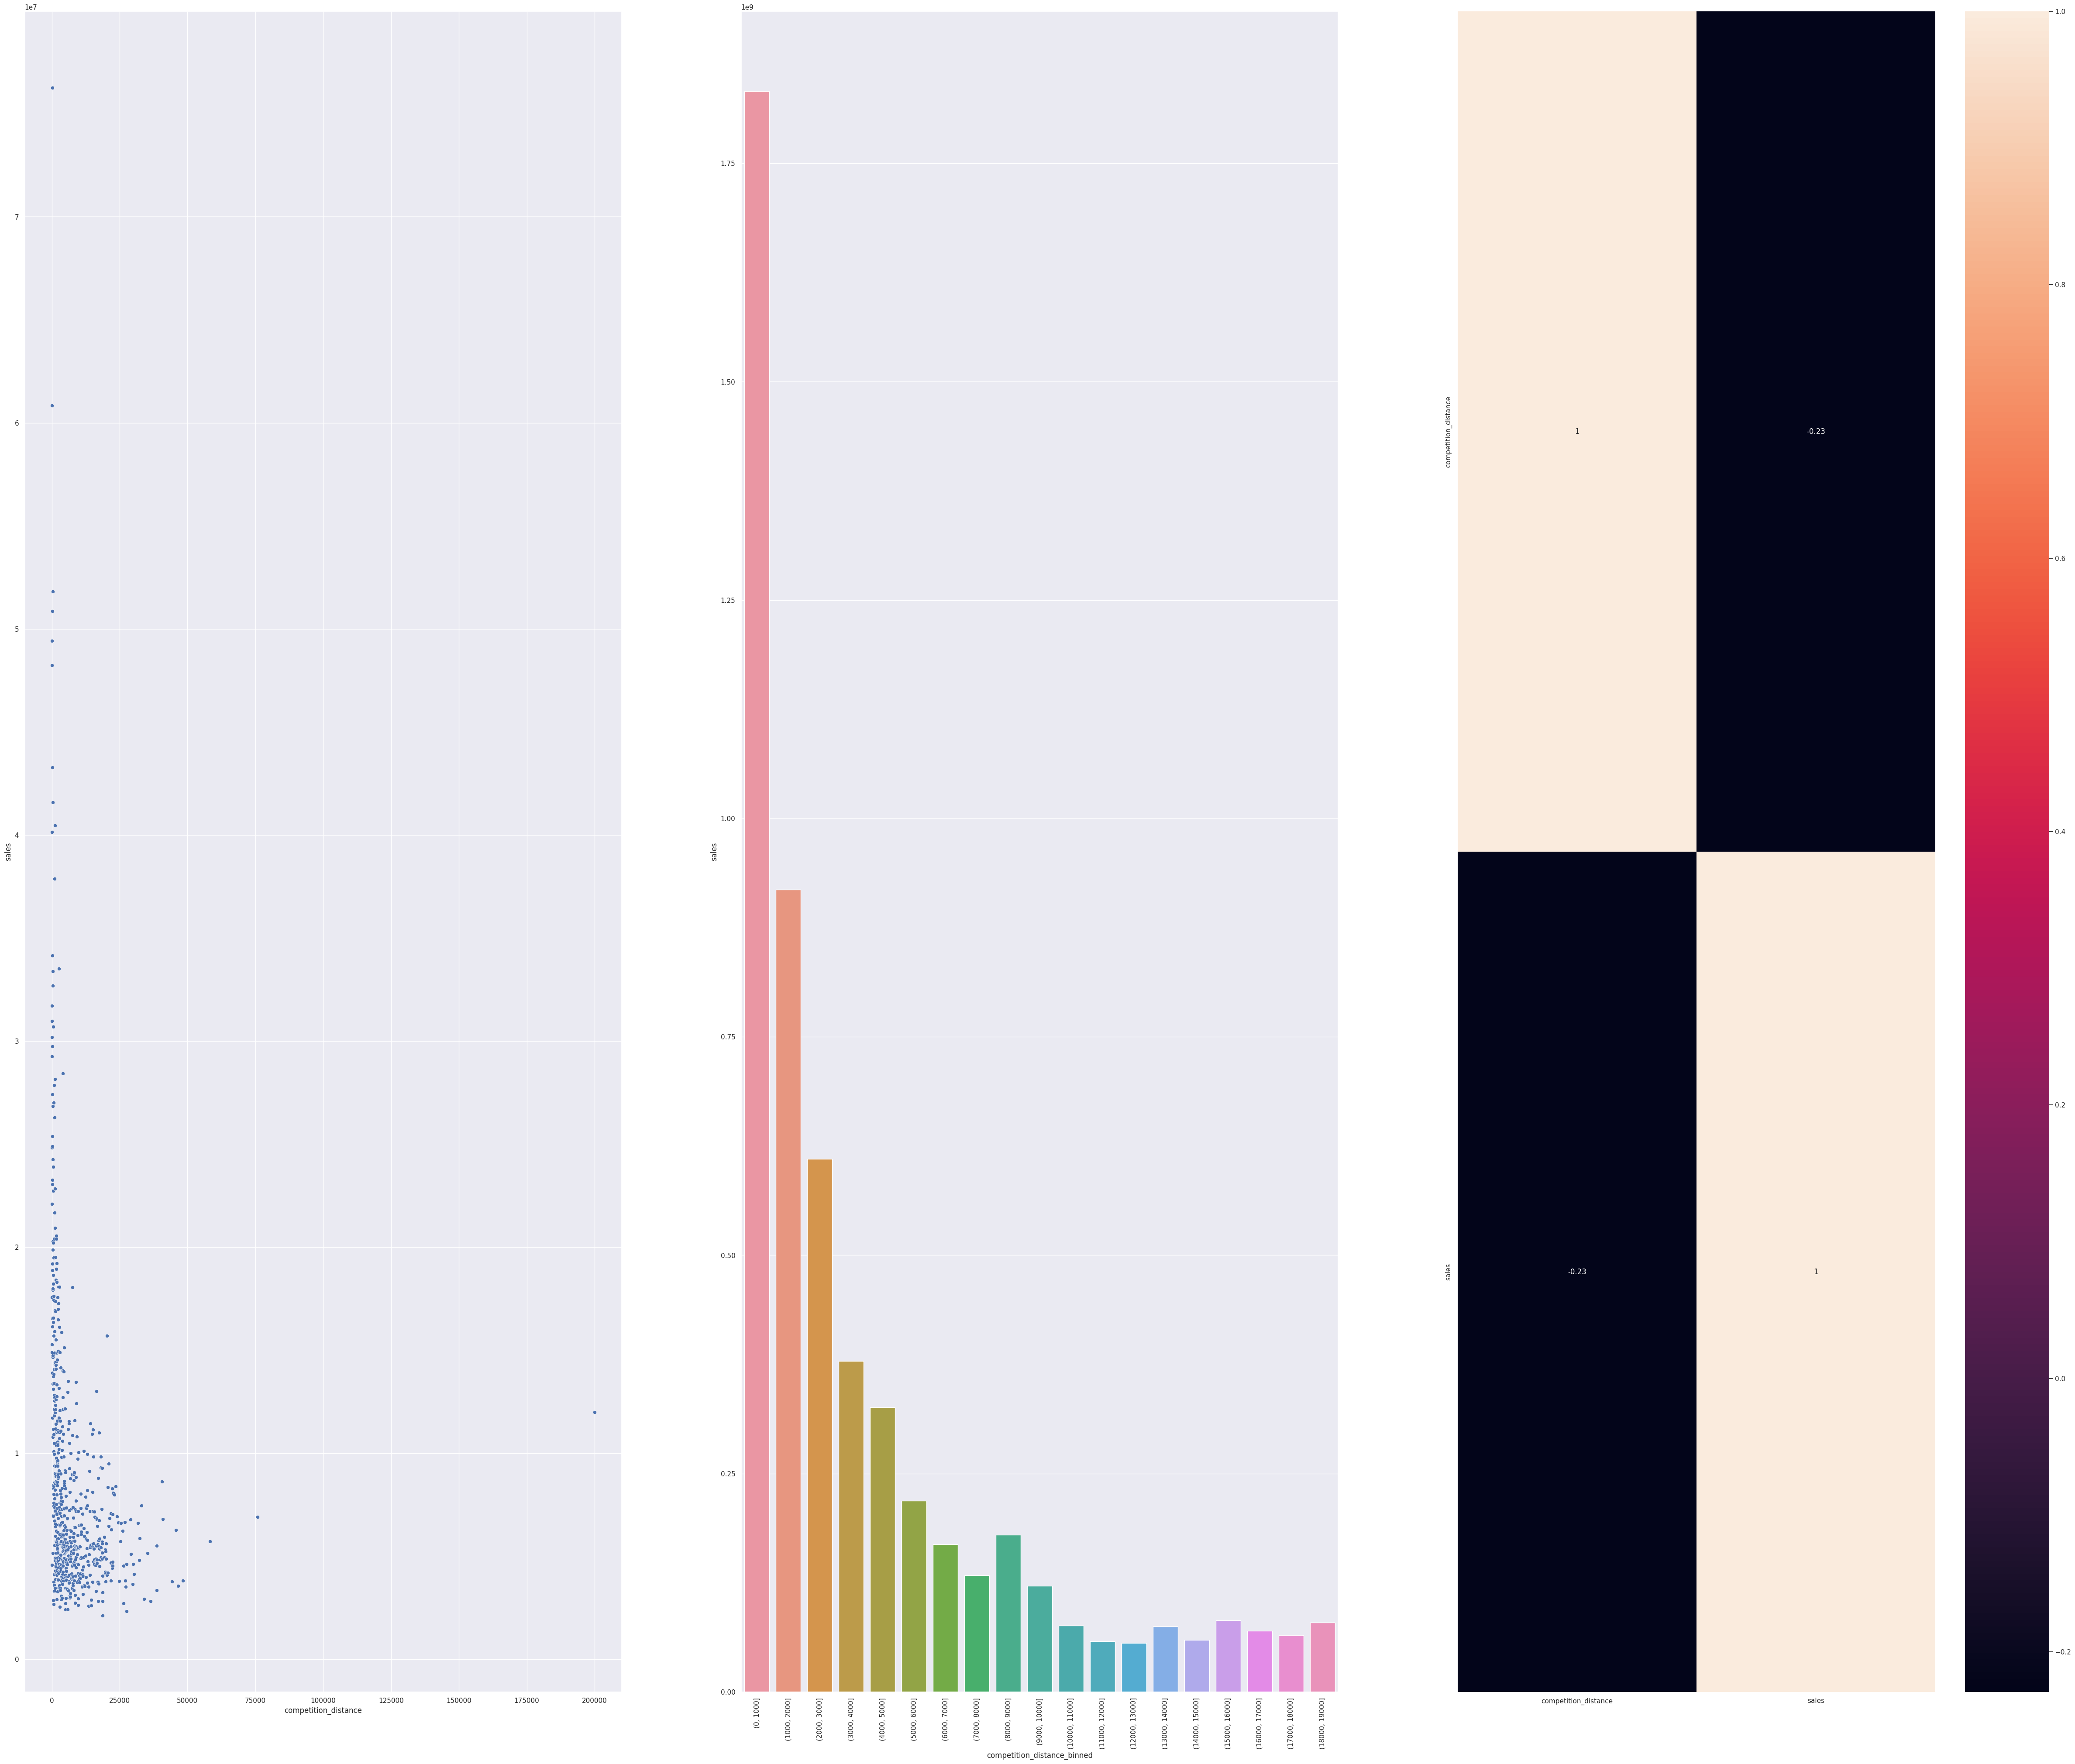

In [120]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
bins = list(np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot( 1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
## caso o valor da correlação esteja deslocado
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0,5, top-0,5);

#### **H3** Lojas com competidores àmais tempo deveriam vender mais.
**Falsa** - lojas com competidores à mais tempo vendem menos!

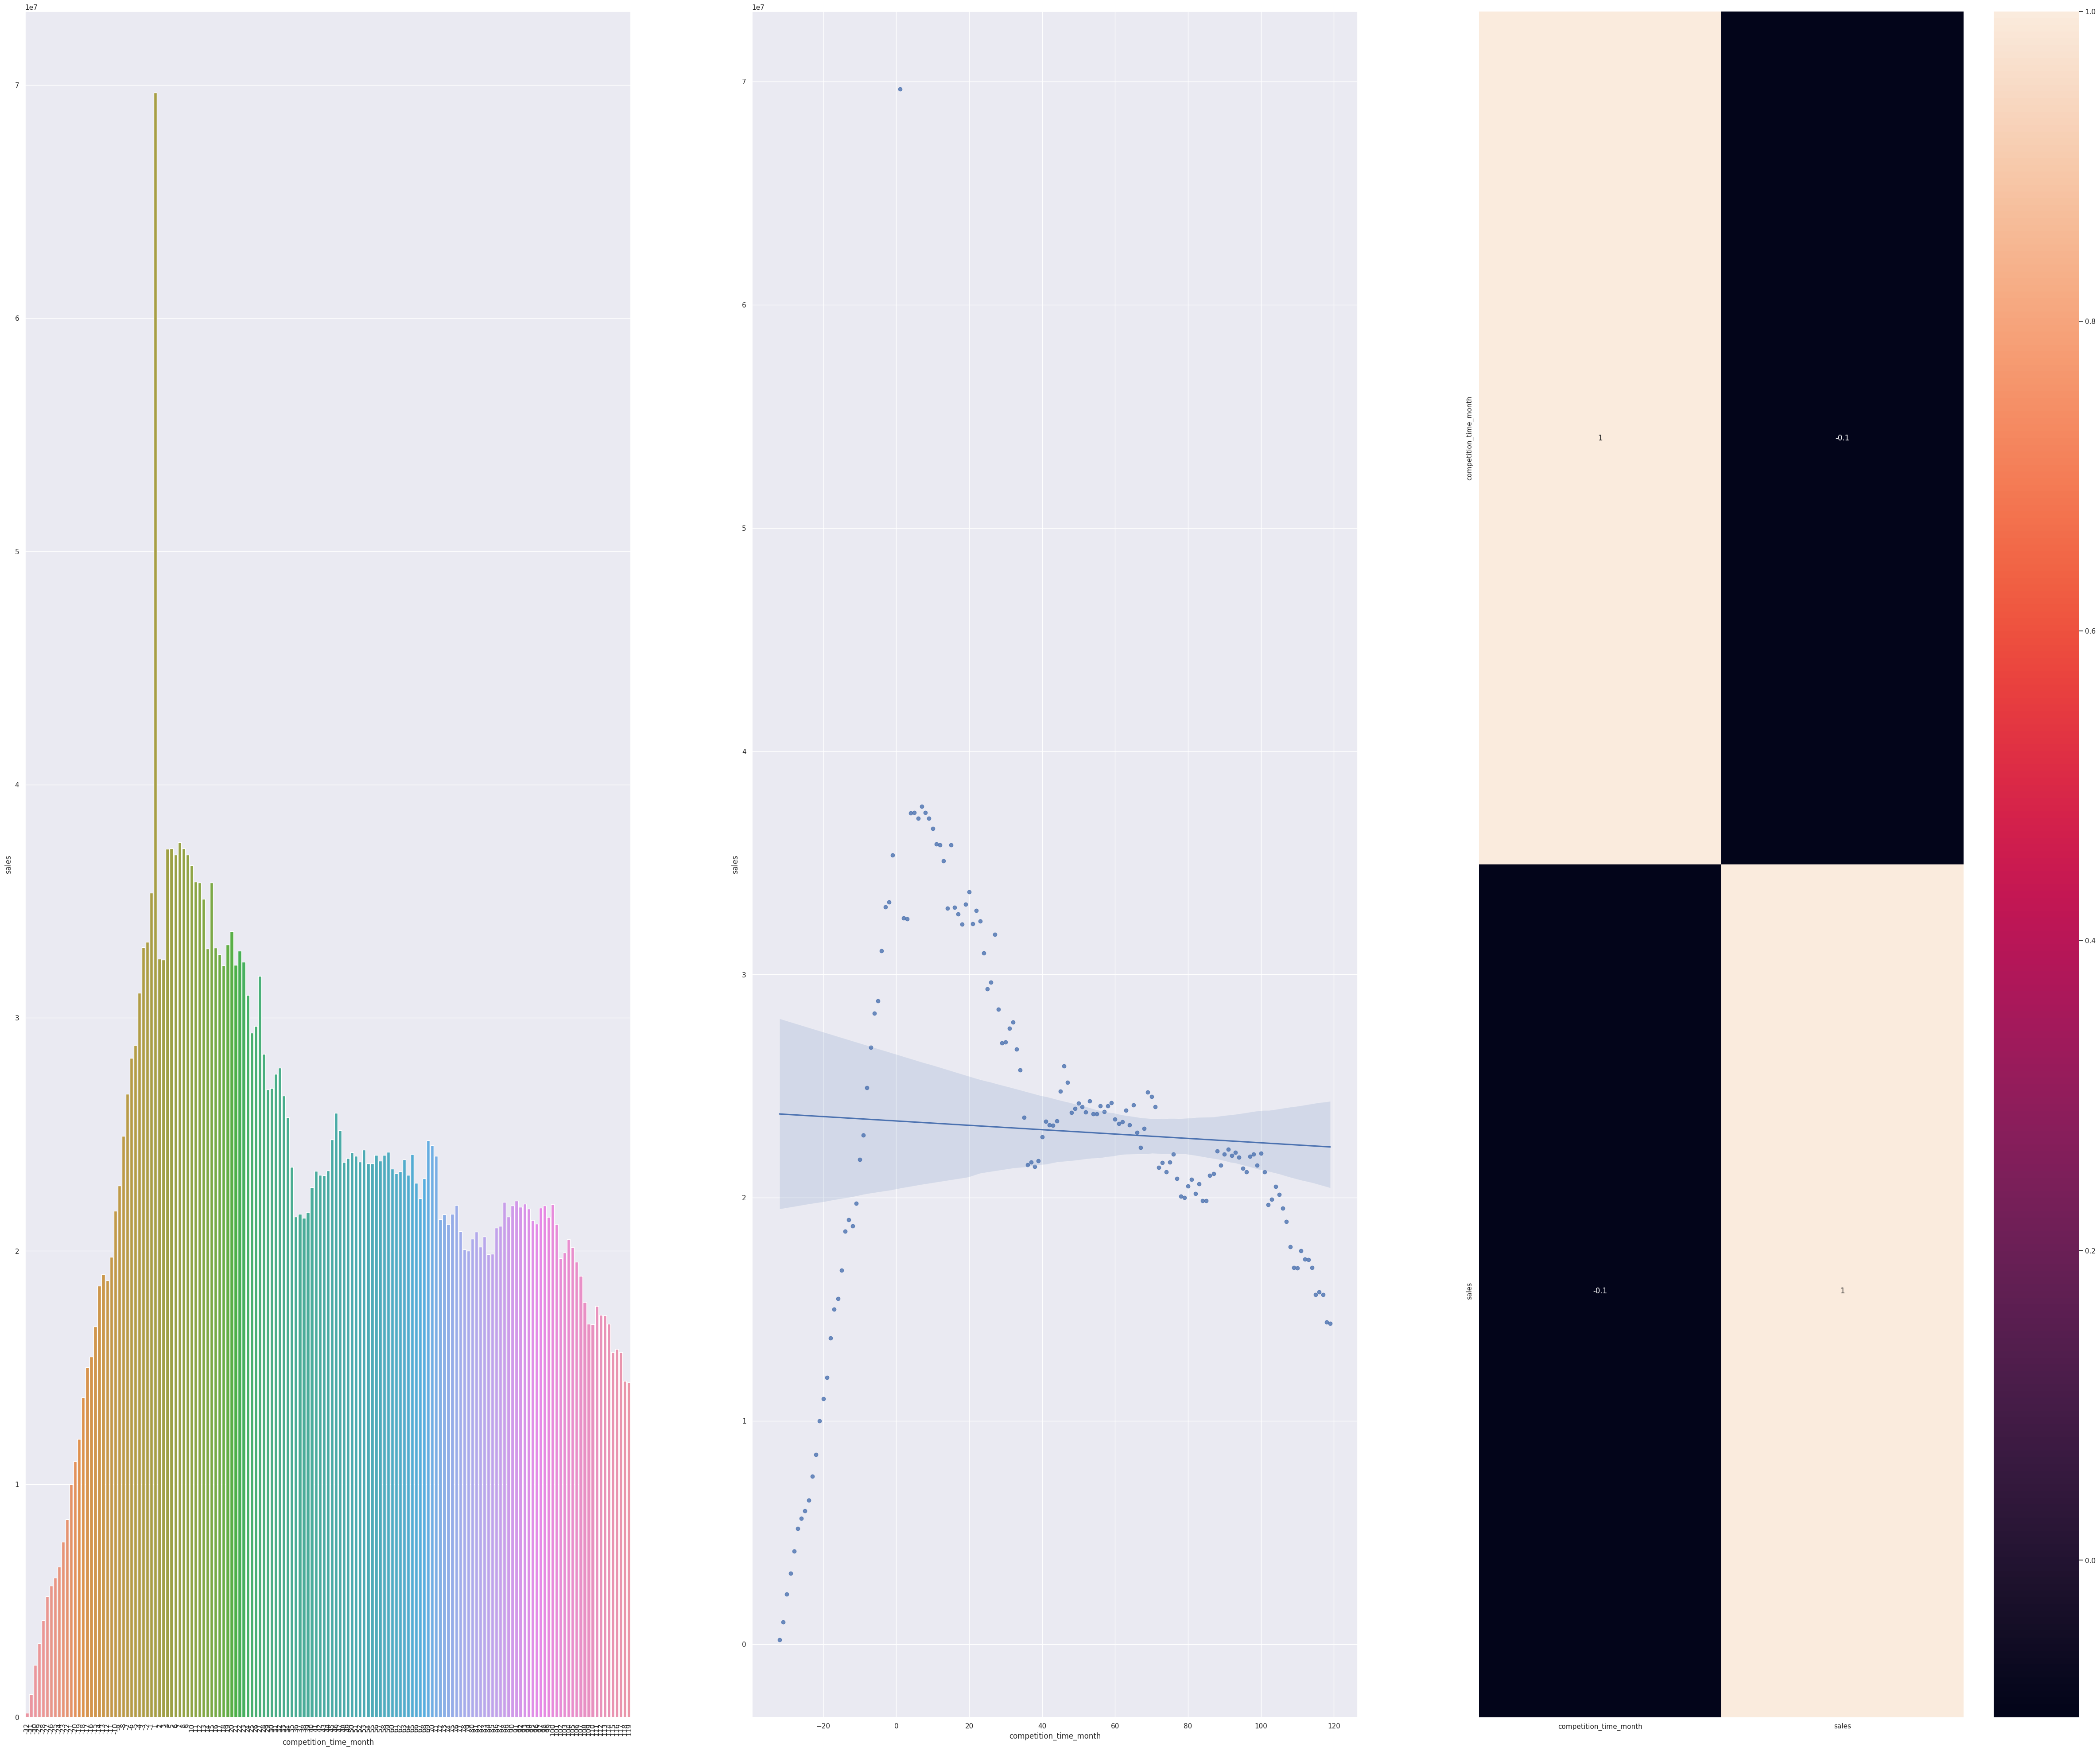

In [121]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5);

#### **H4** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa** - lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção.

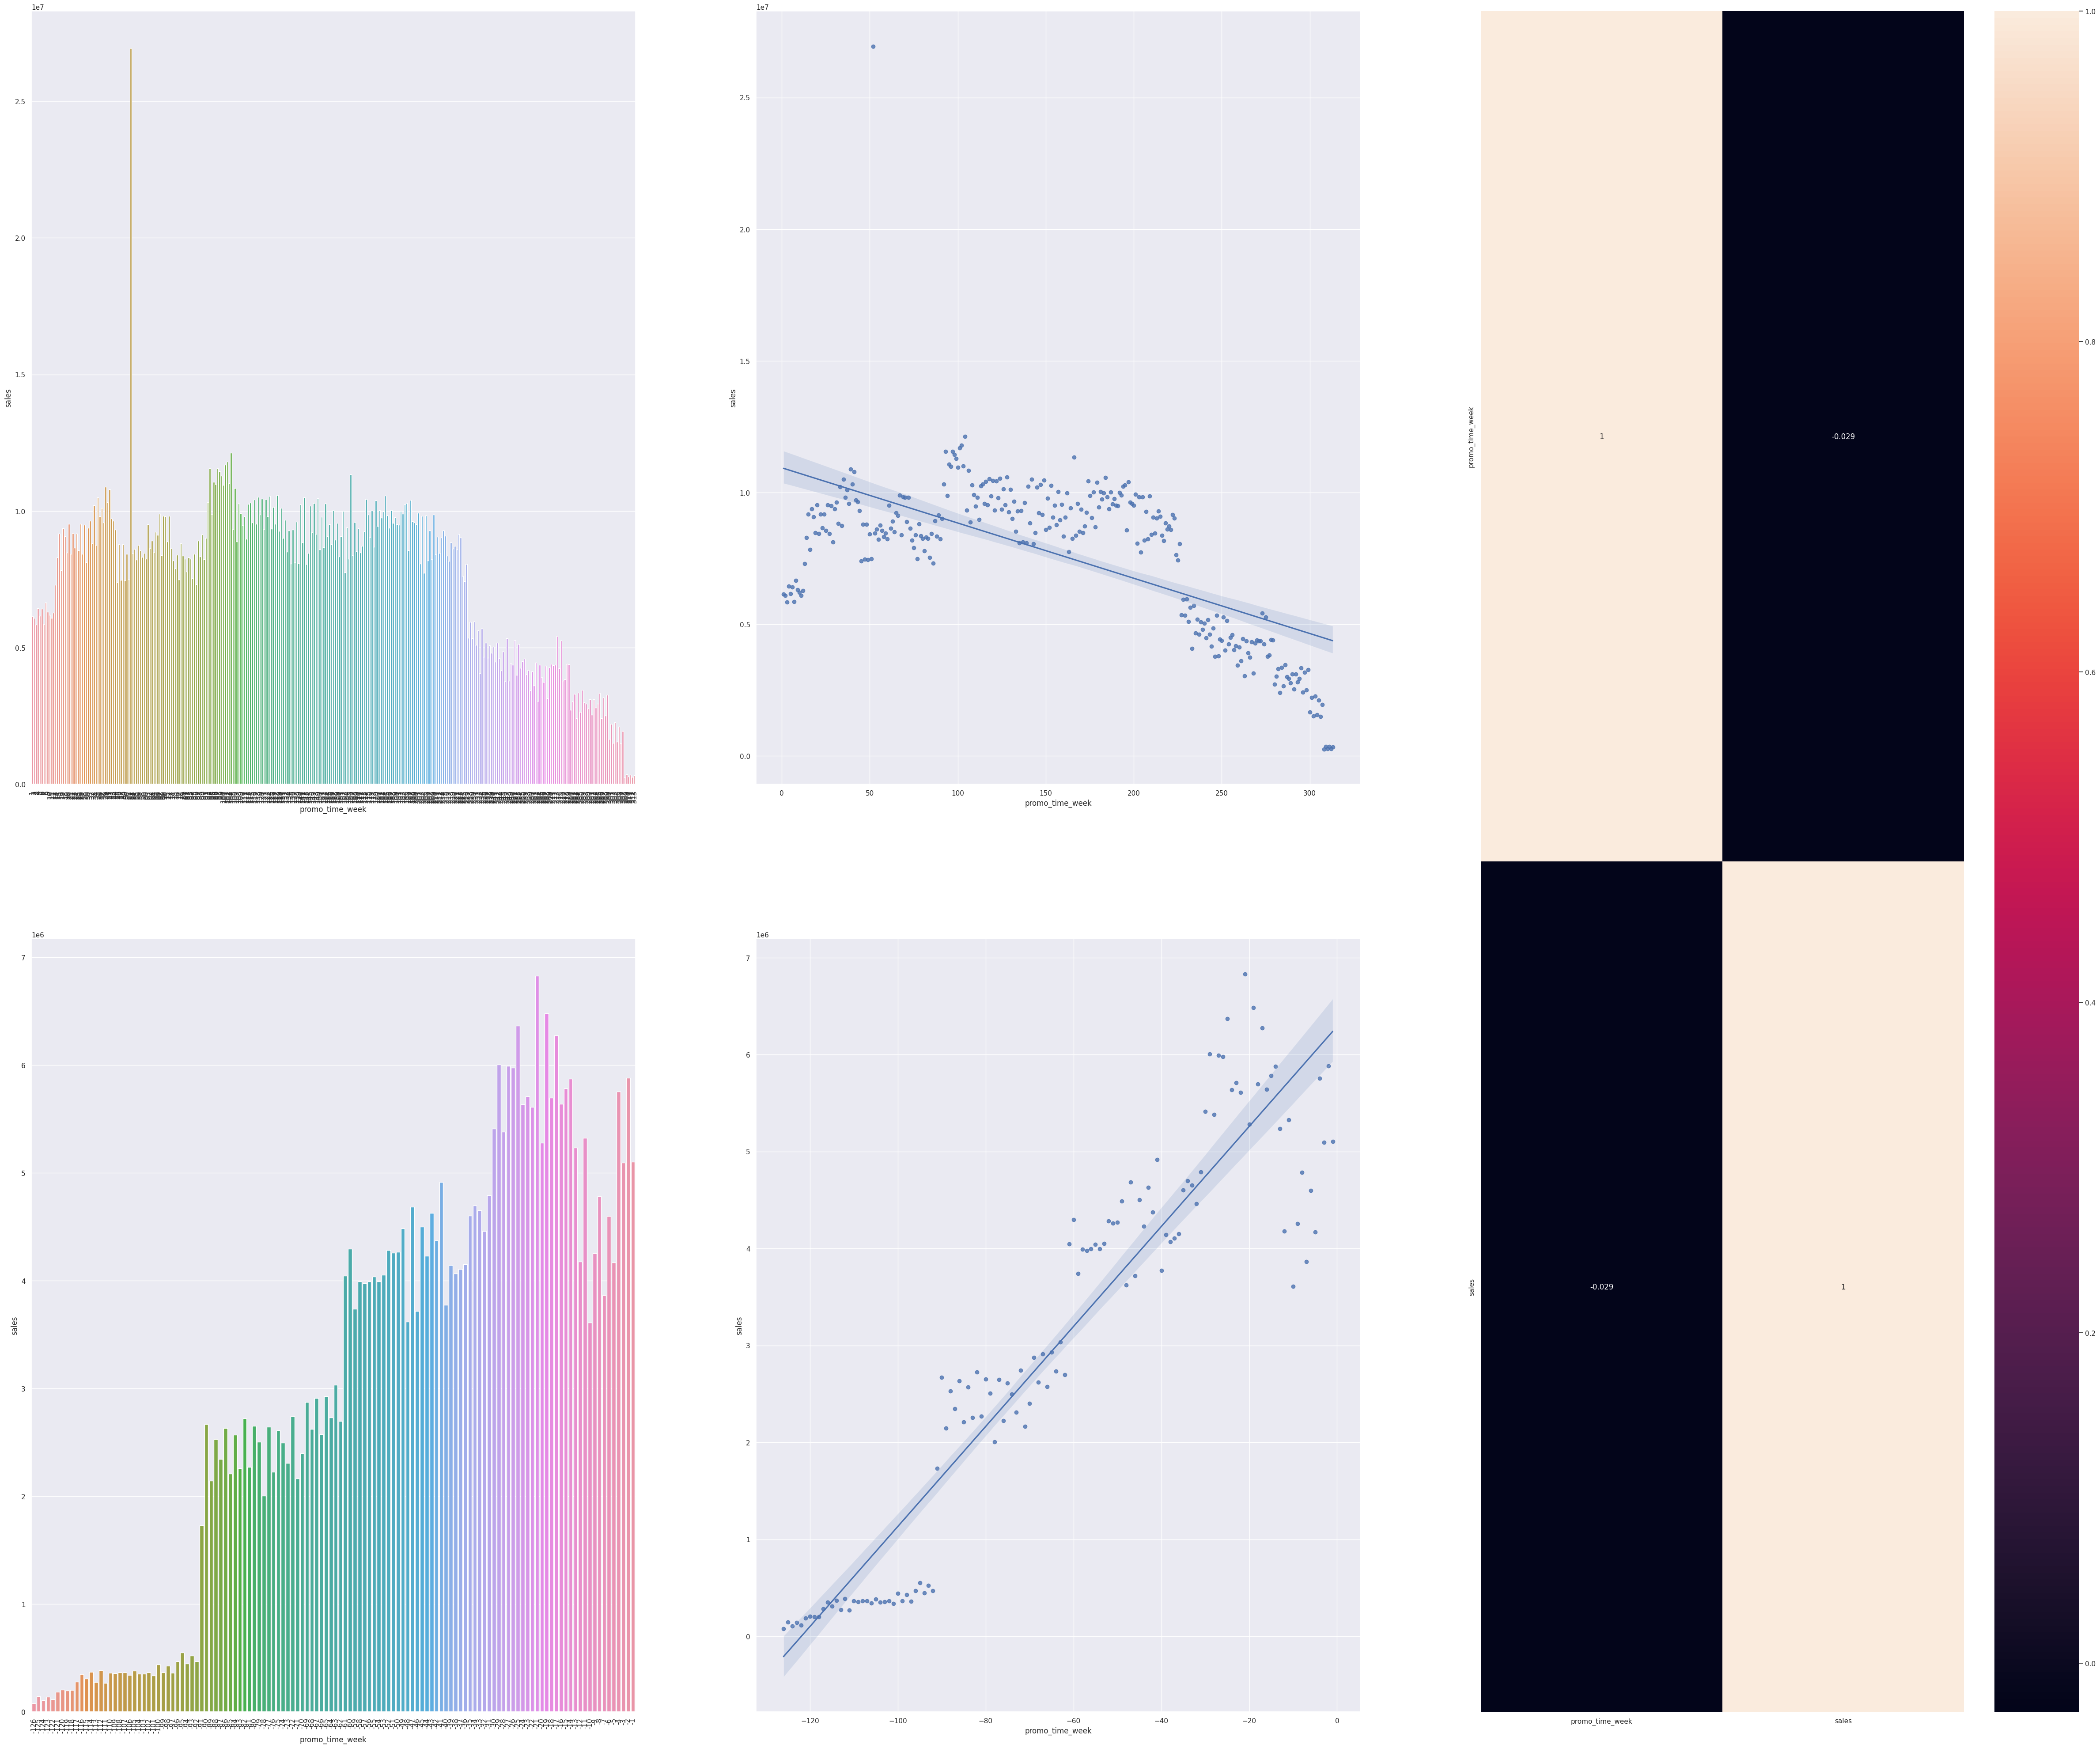

In [122]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H5** Lojas com mais dias de promoção deveriam vender mais.

#### **H6** Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa** - lojas com mais promoções consecutivas vendem menos!

In [123]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

promo  promo2       sales
0      0       0  1482612096
1      0       1  1289362241
2      1       0  1628930532
3      1       1  1472275754

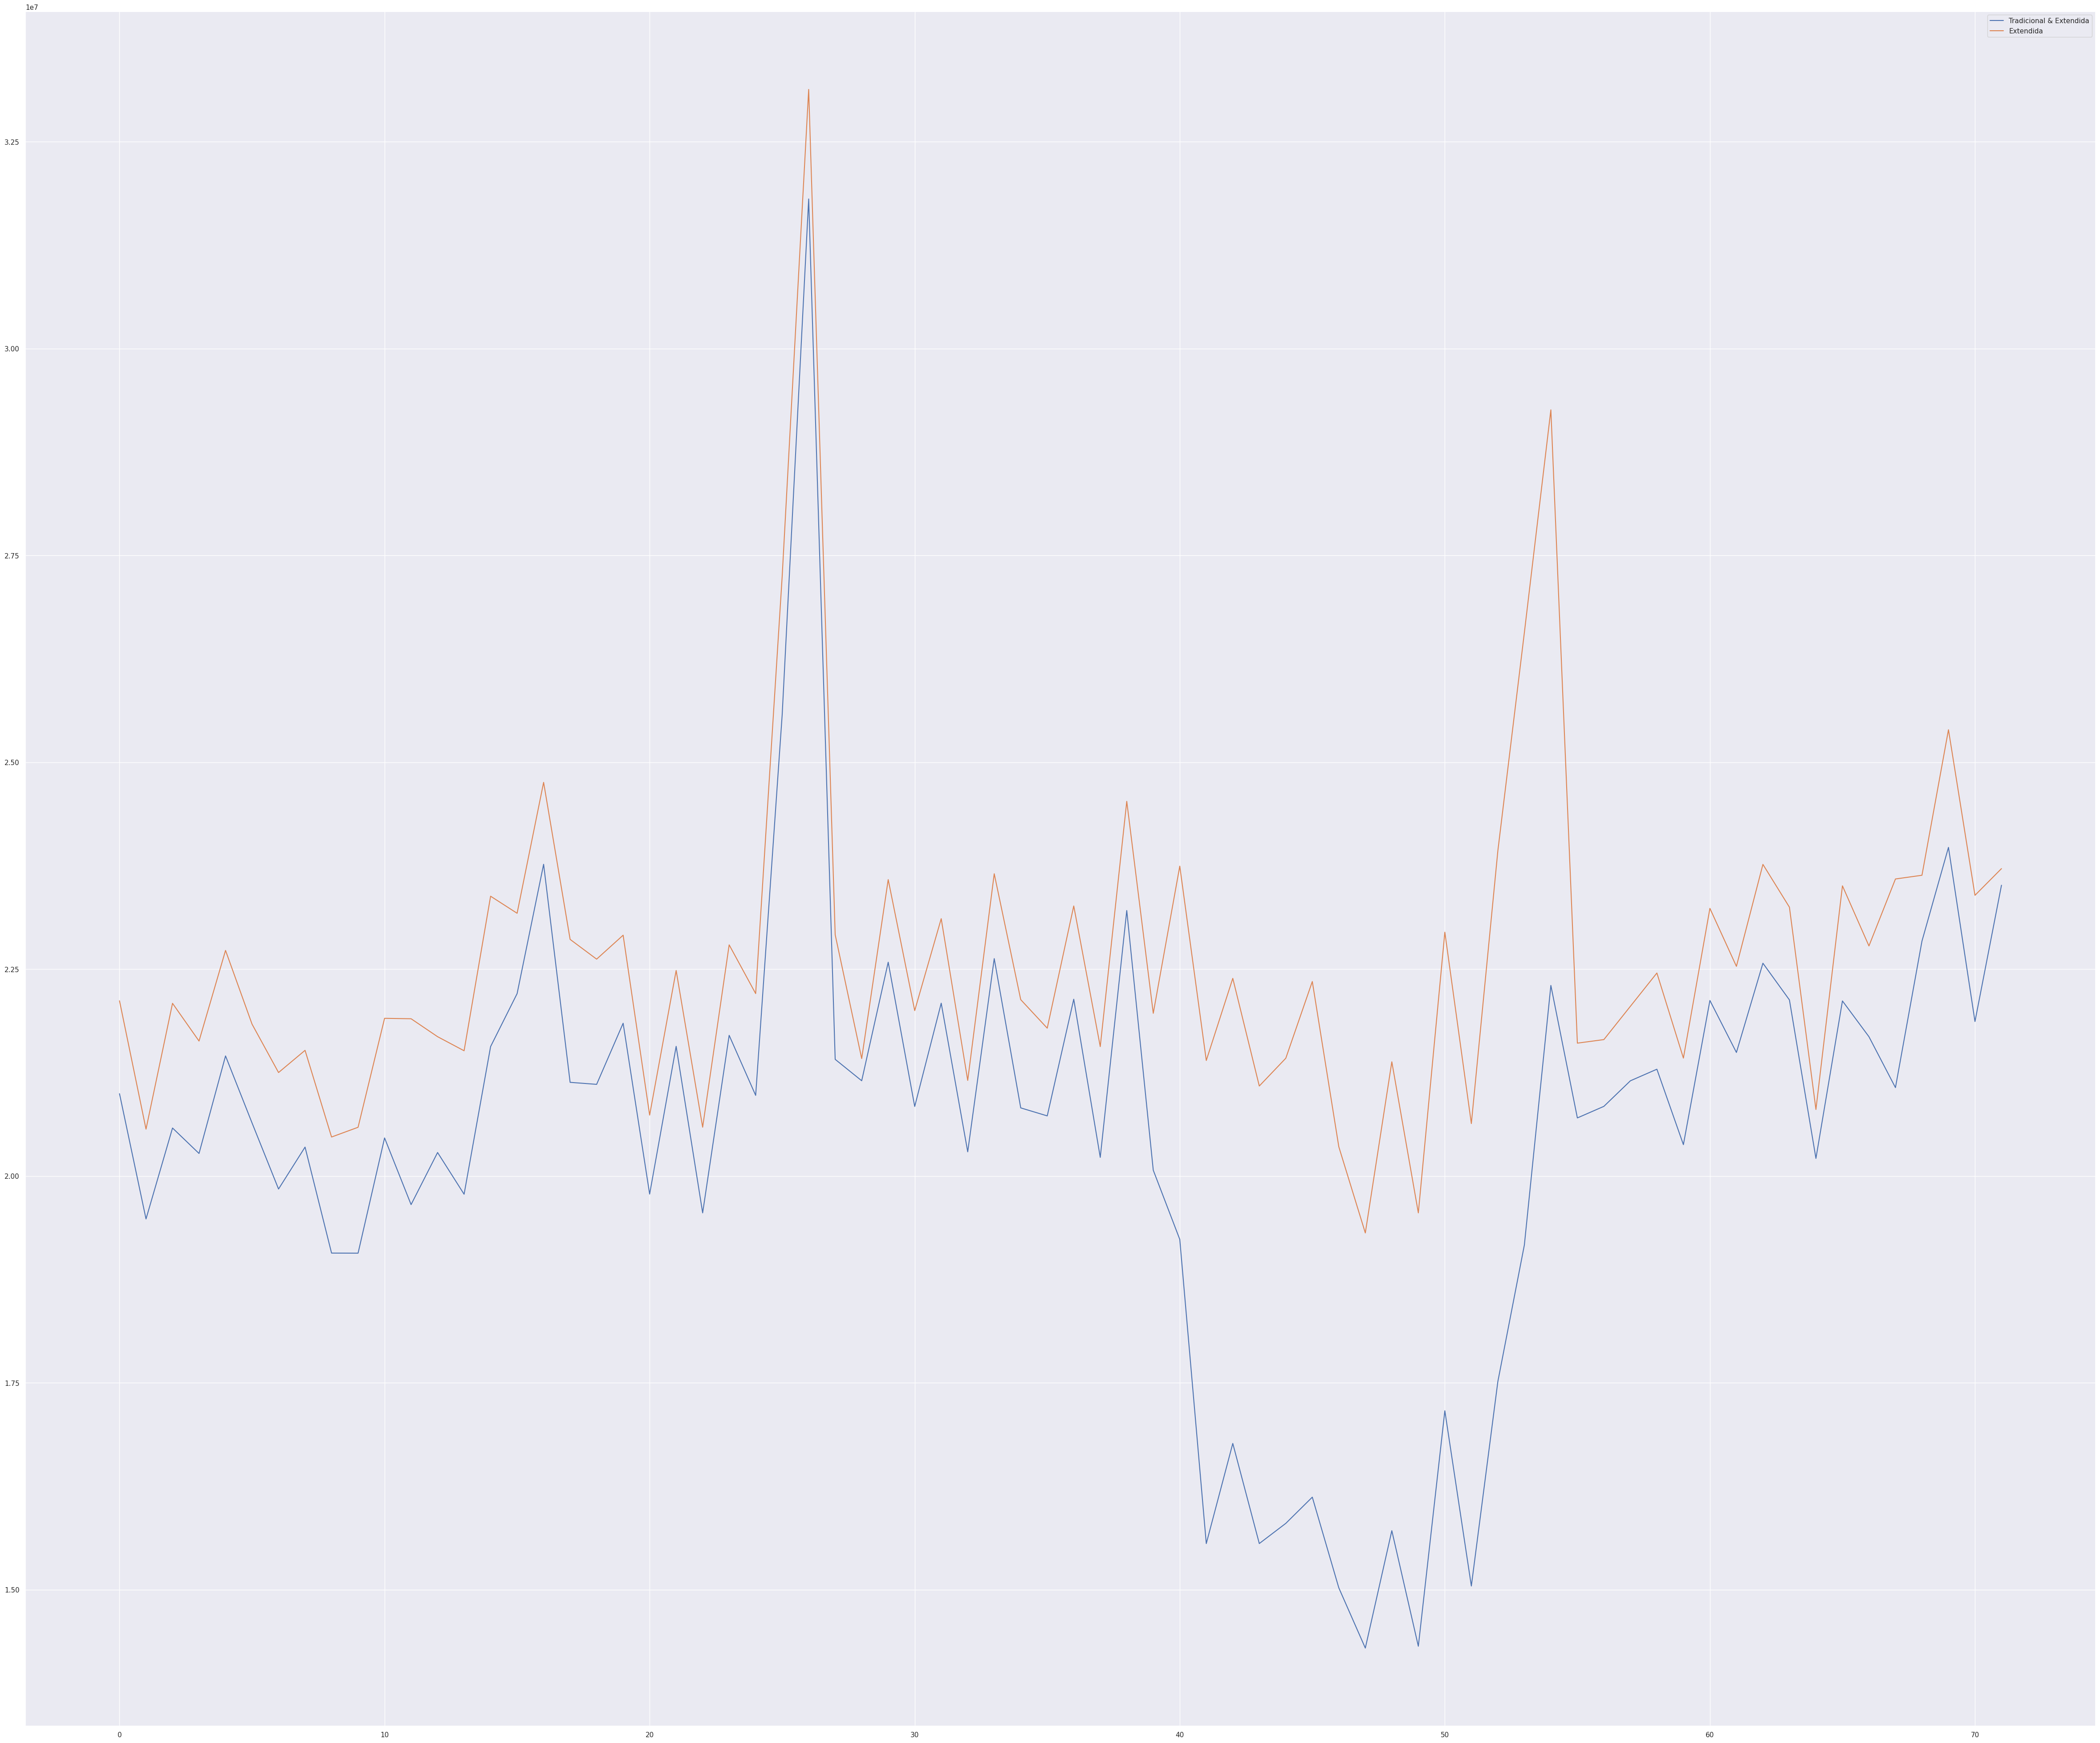

In [124]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

#### **H7** Lojas abertas durante o feriado de Natal deveriam vender mais
**Falsa** Lojas abertas durante o feriado do Natal vendem menos!

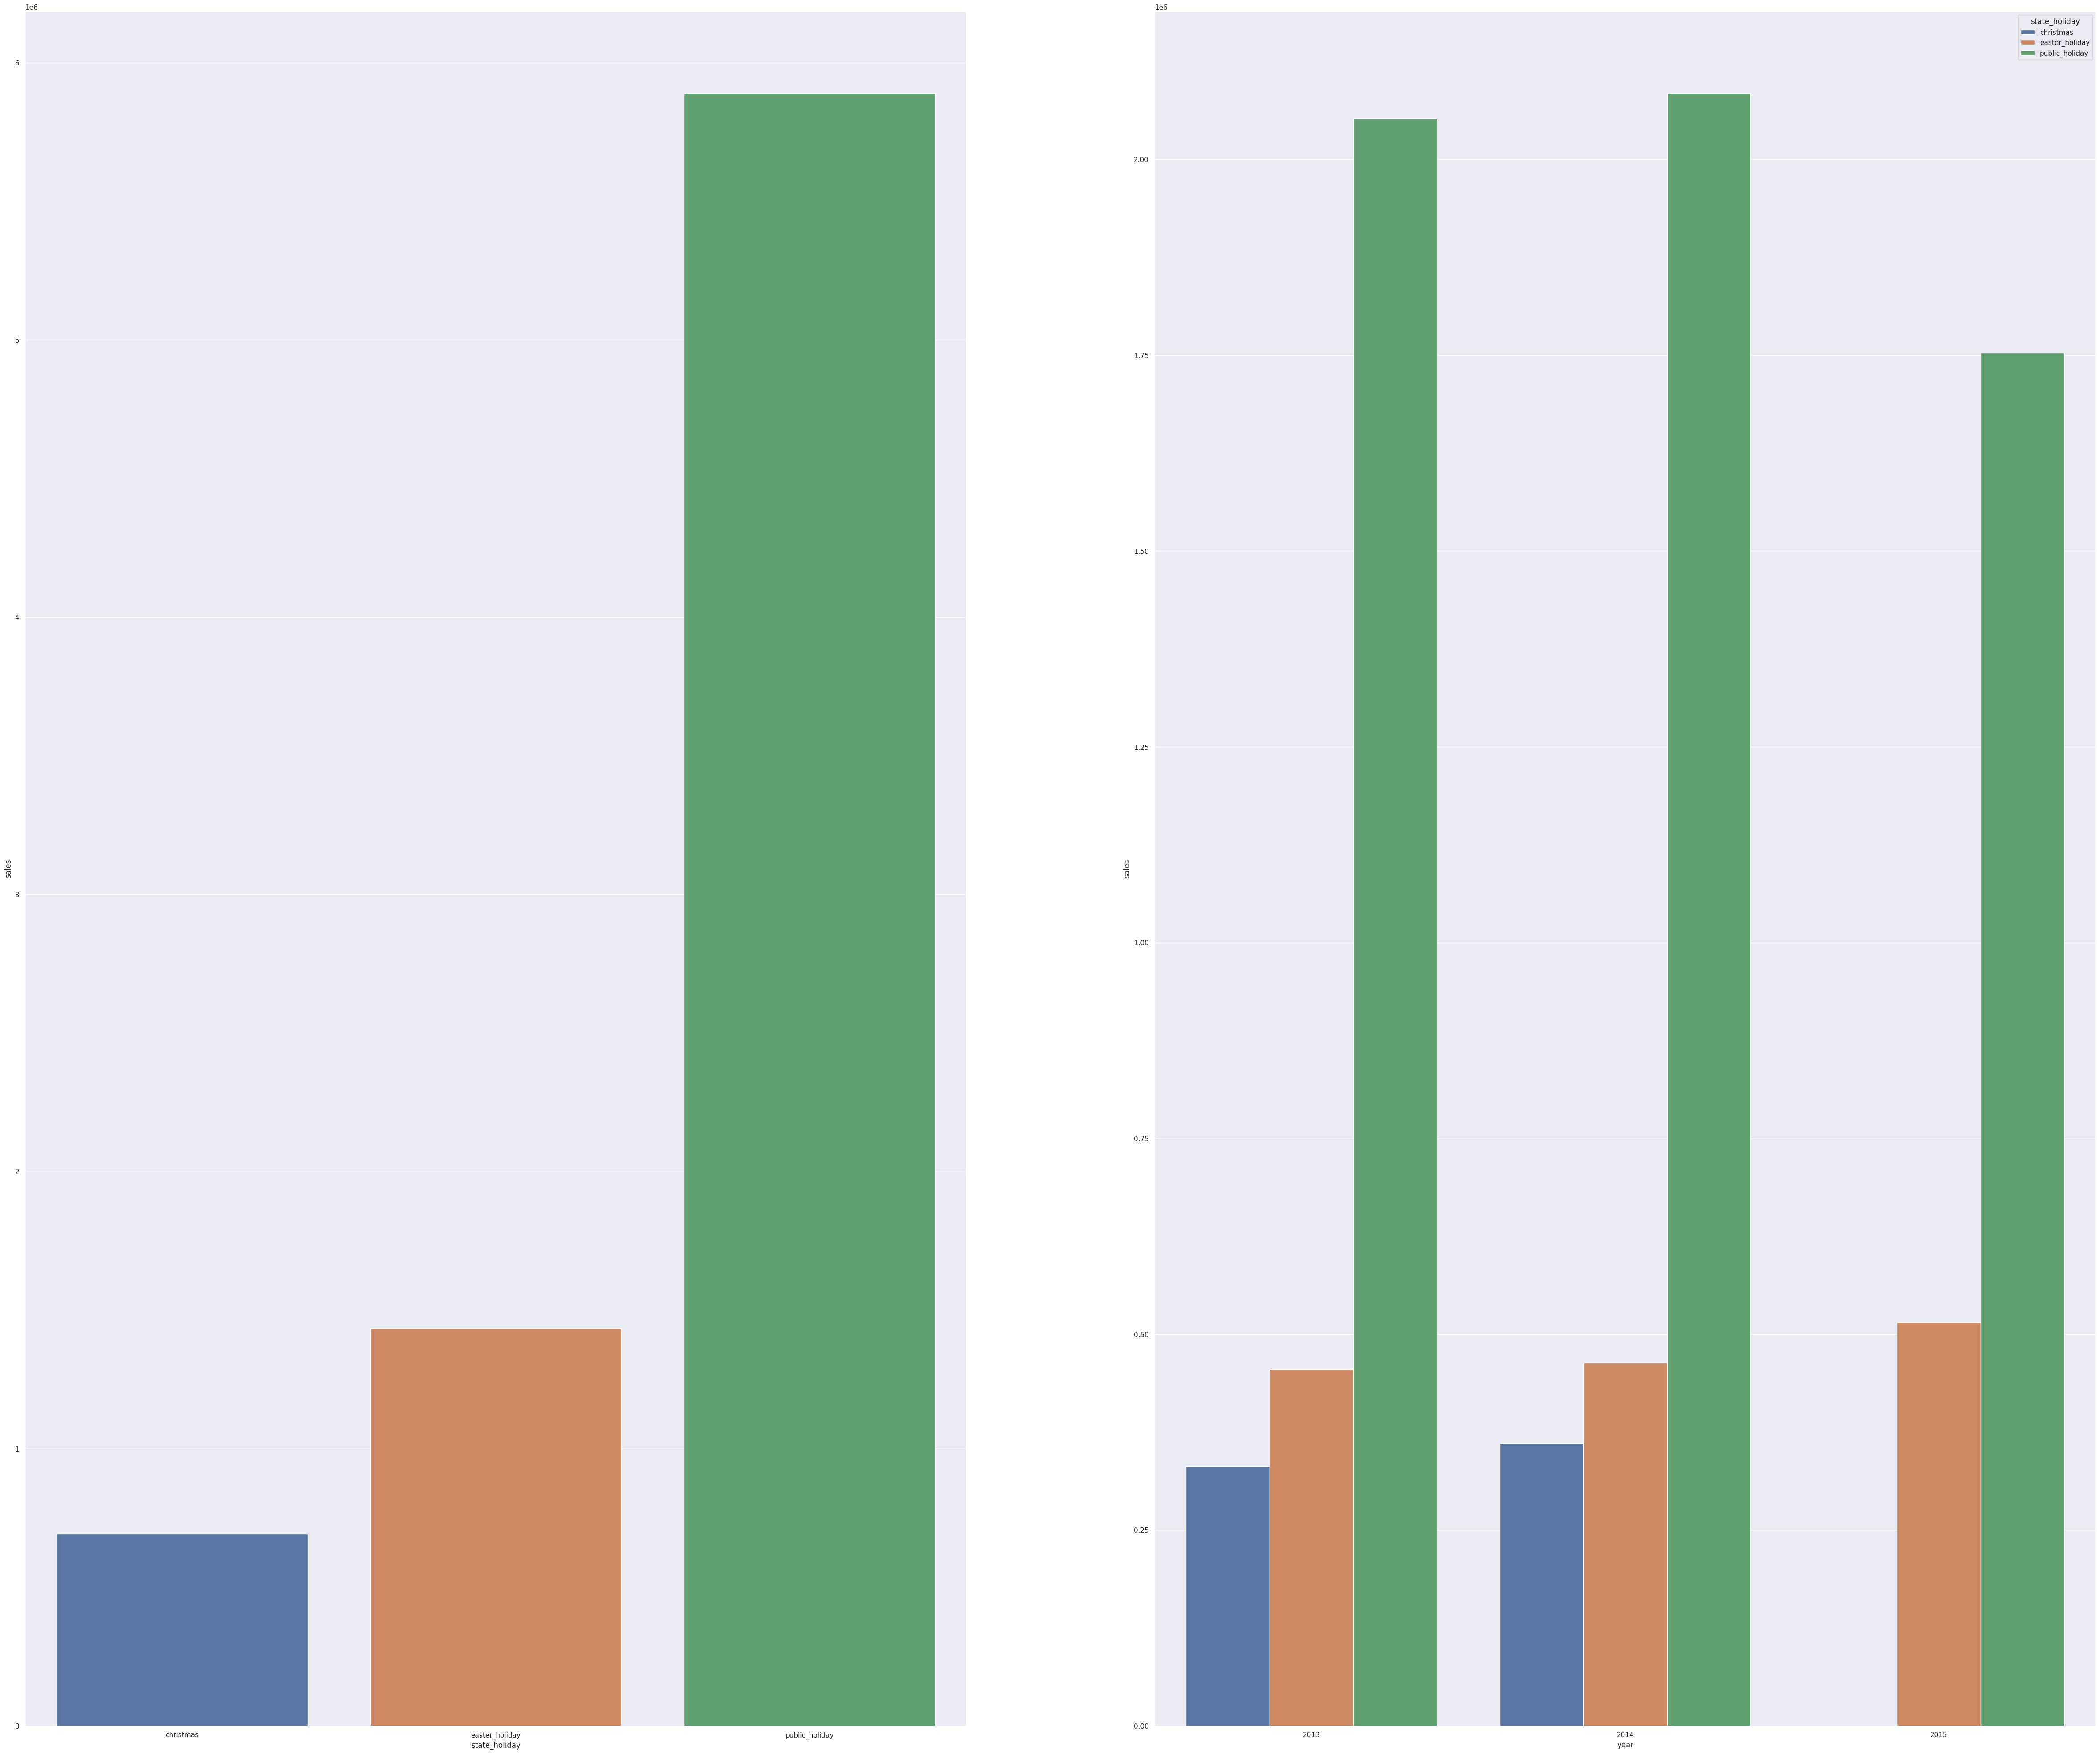

In [125]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### **H8** Lojas deveriam vender mais ao longo dos anos.
**Falsa** Lojas vendem menos ao longo dos anos.

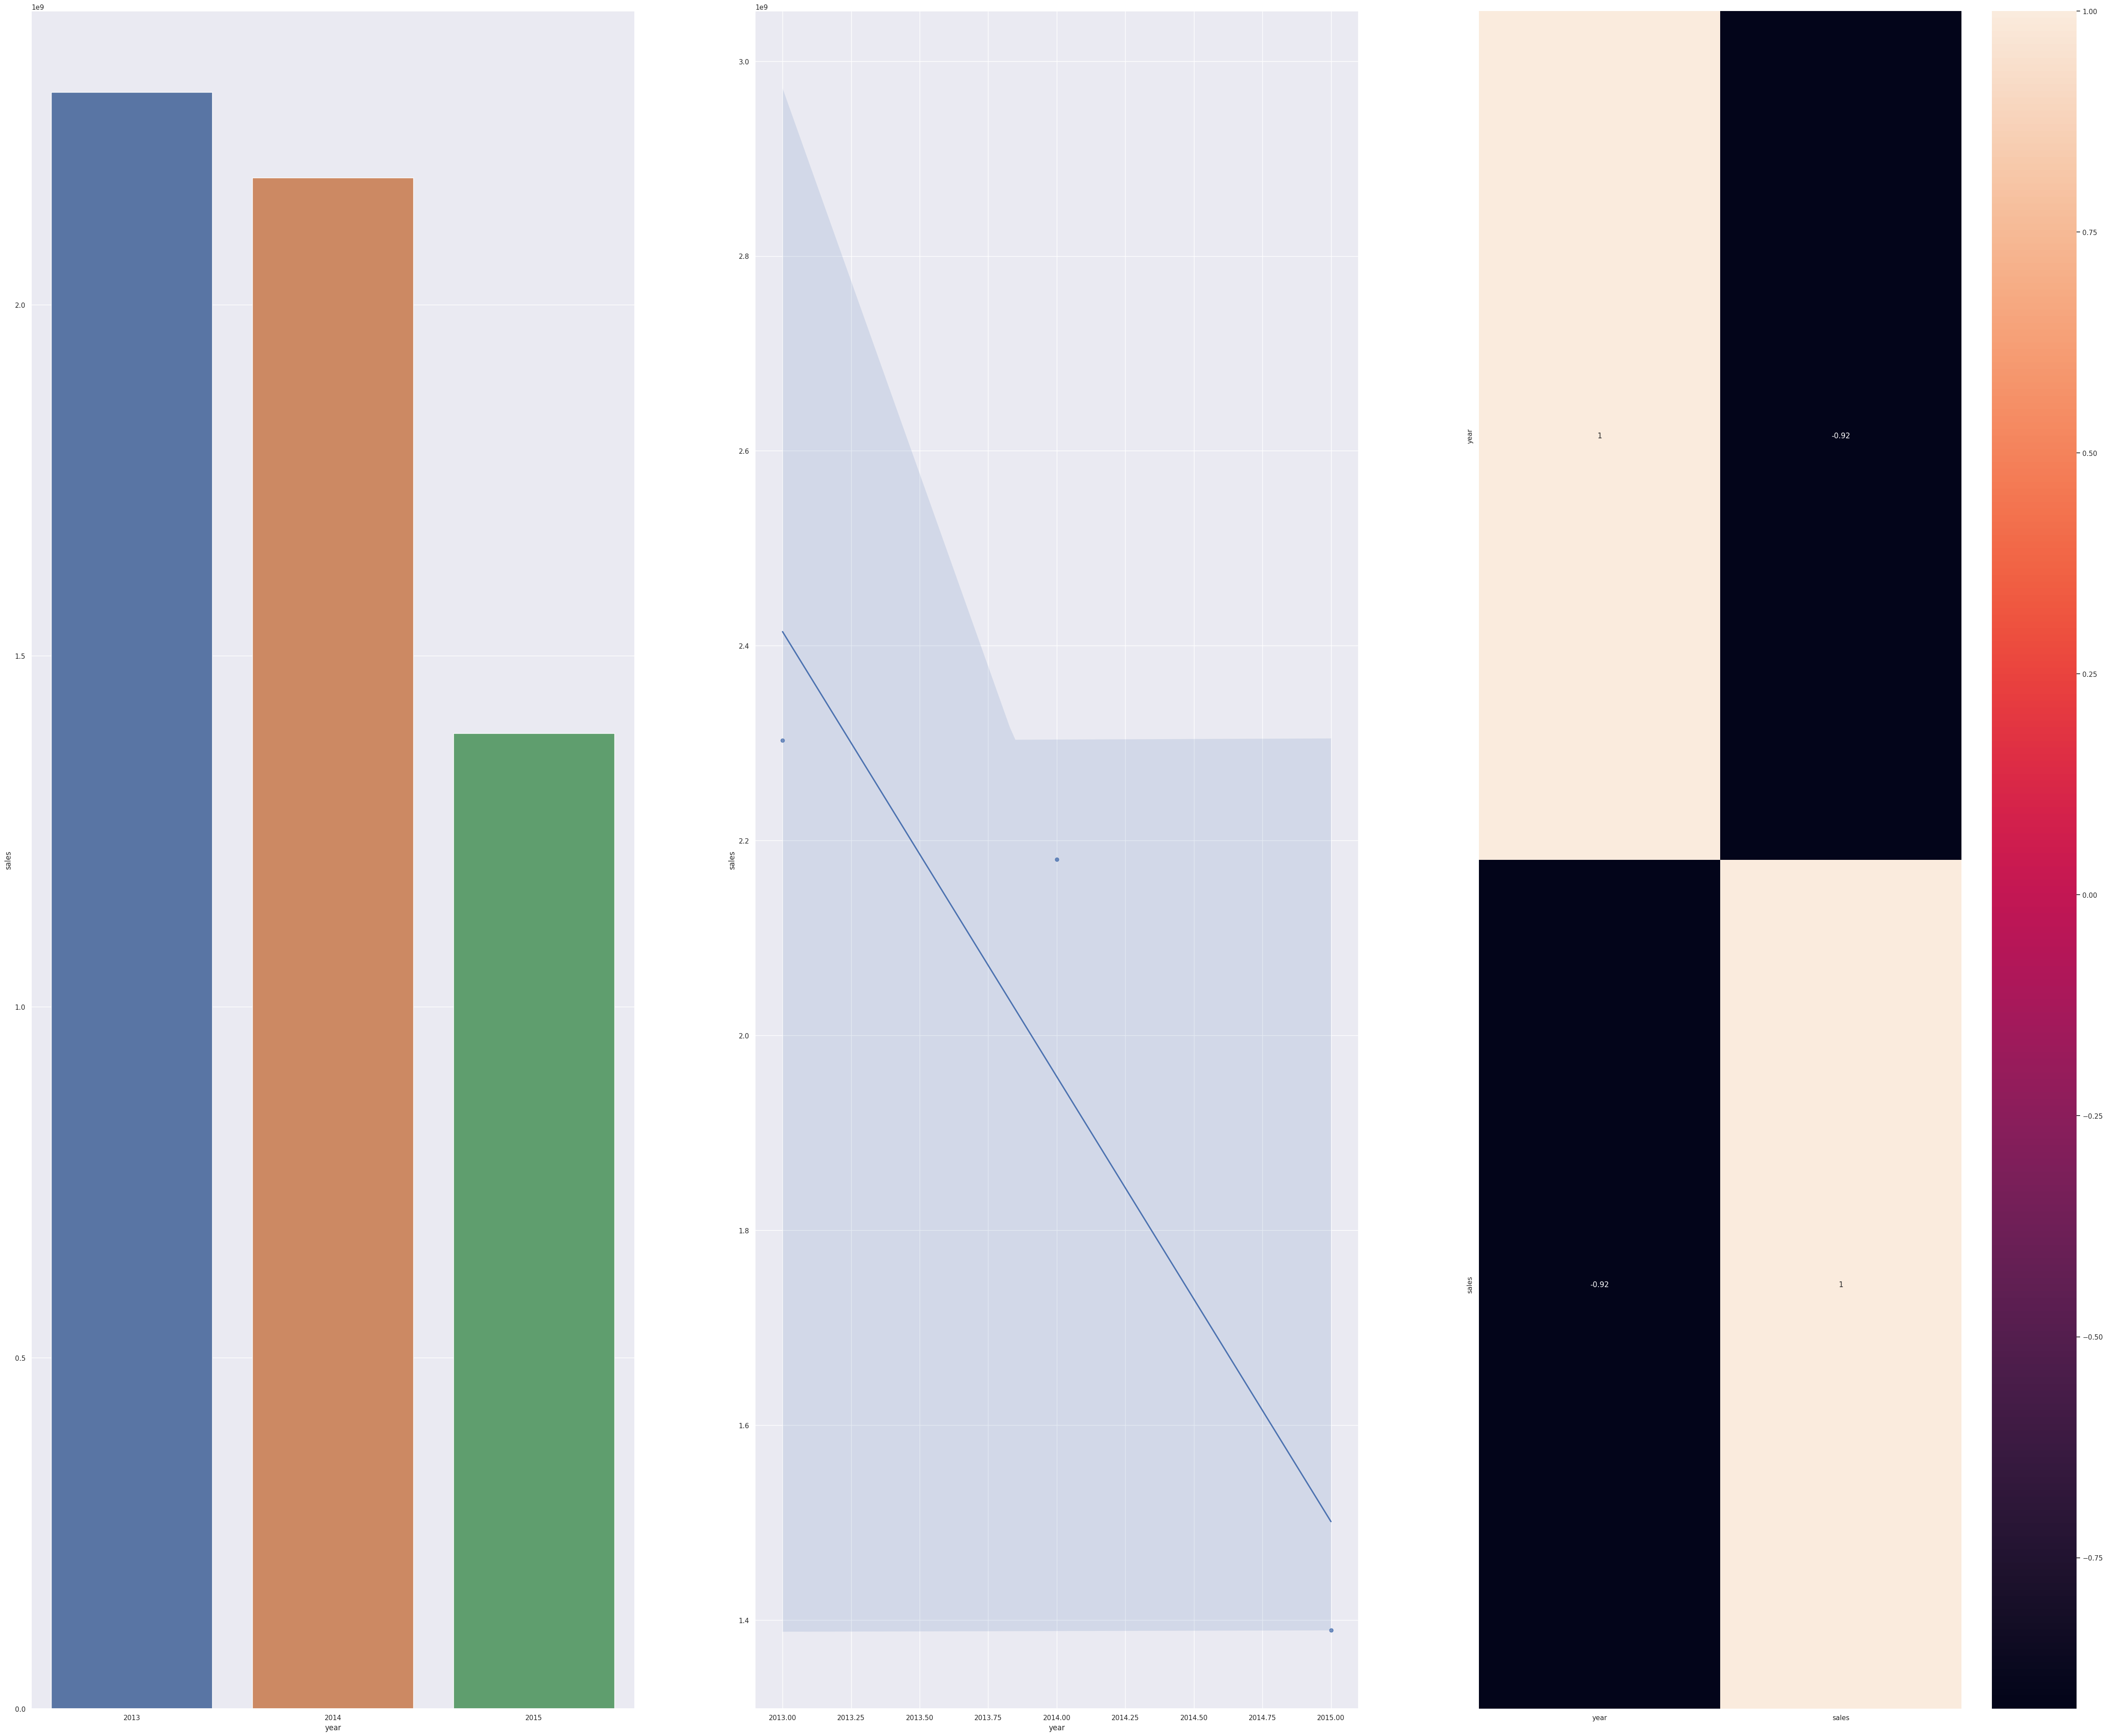

In [126]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H9** Lojas deveriam vender mais no segundo semestre do ano.
**Falsa** - lojas vendem menos no segundo semestre do ano!

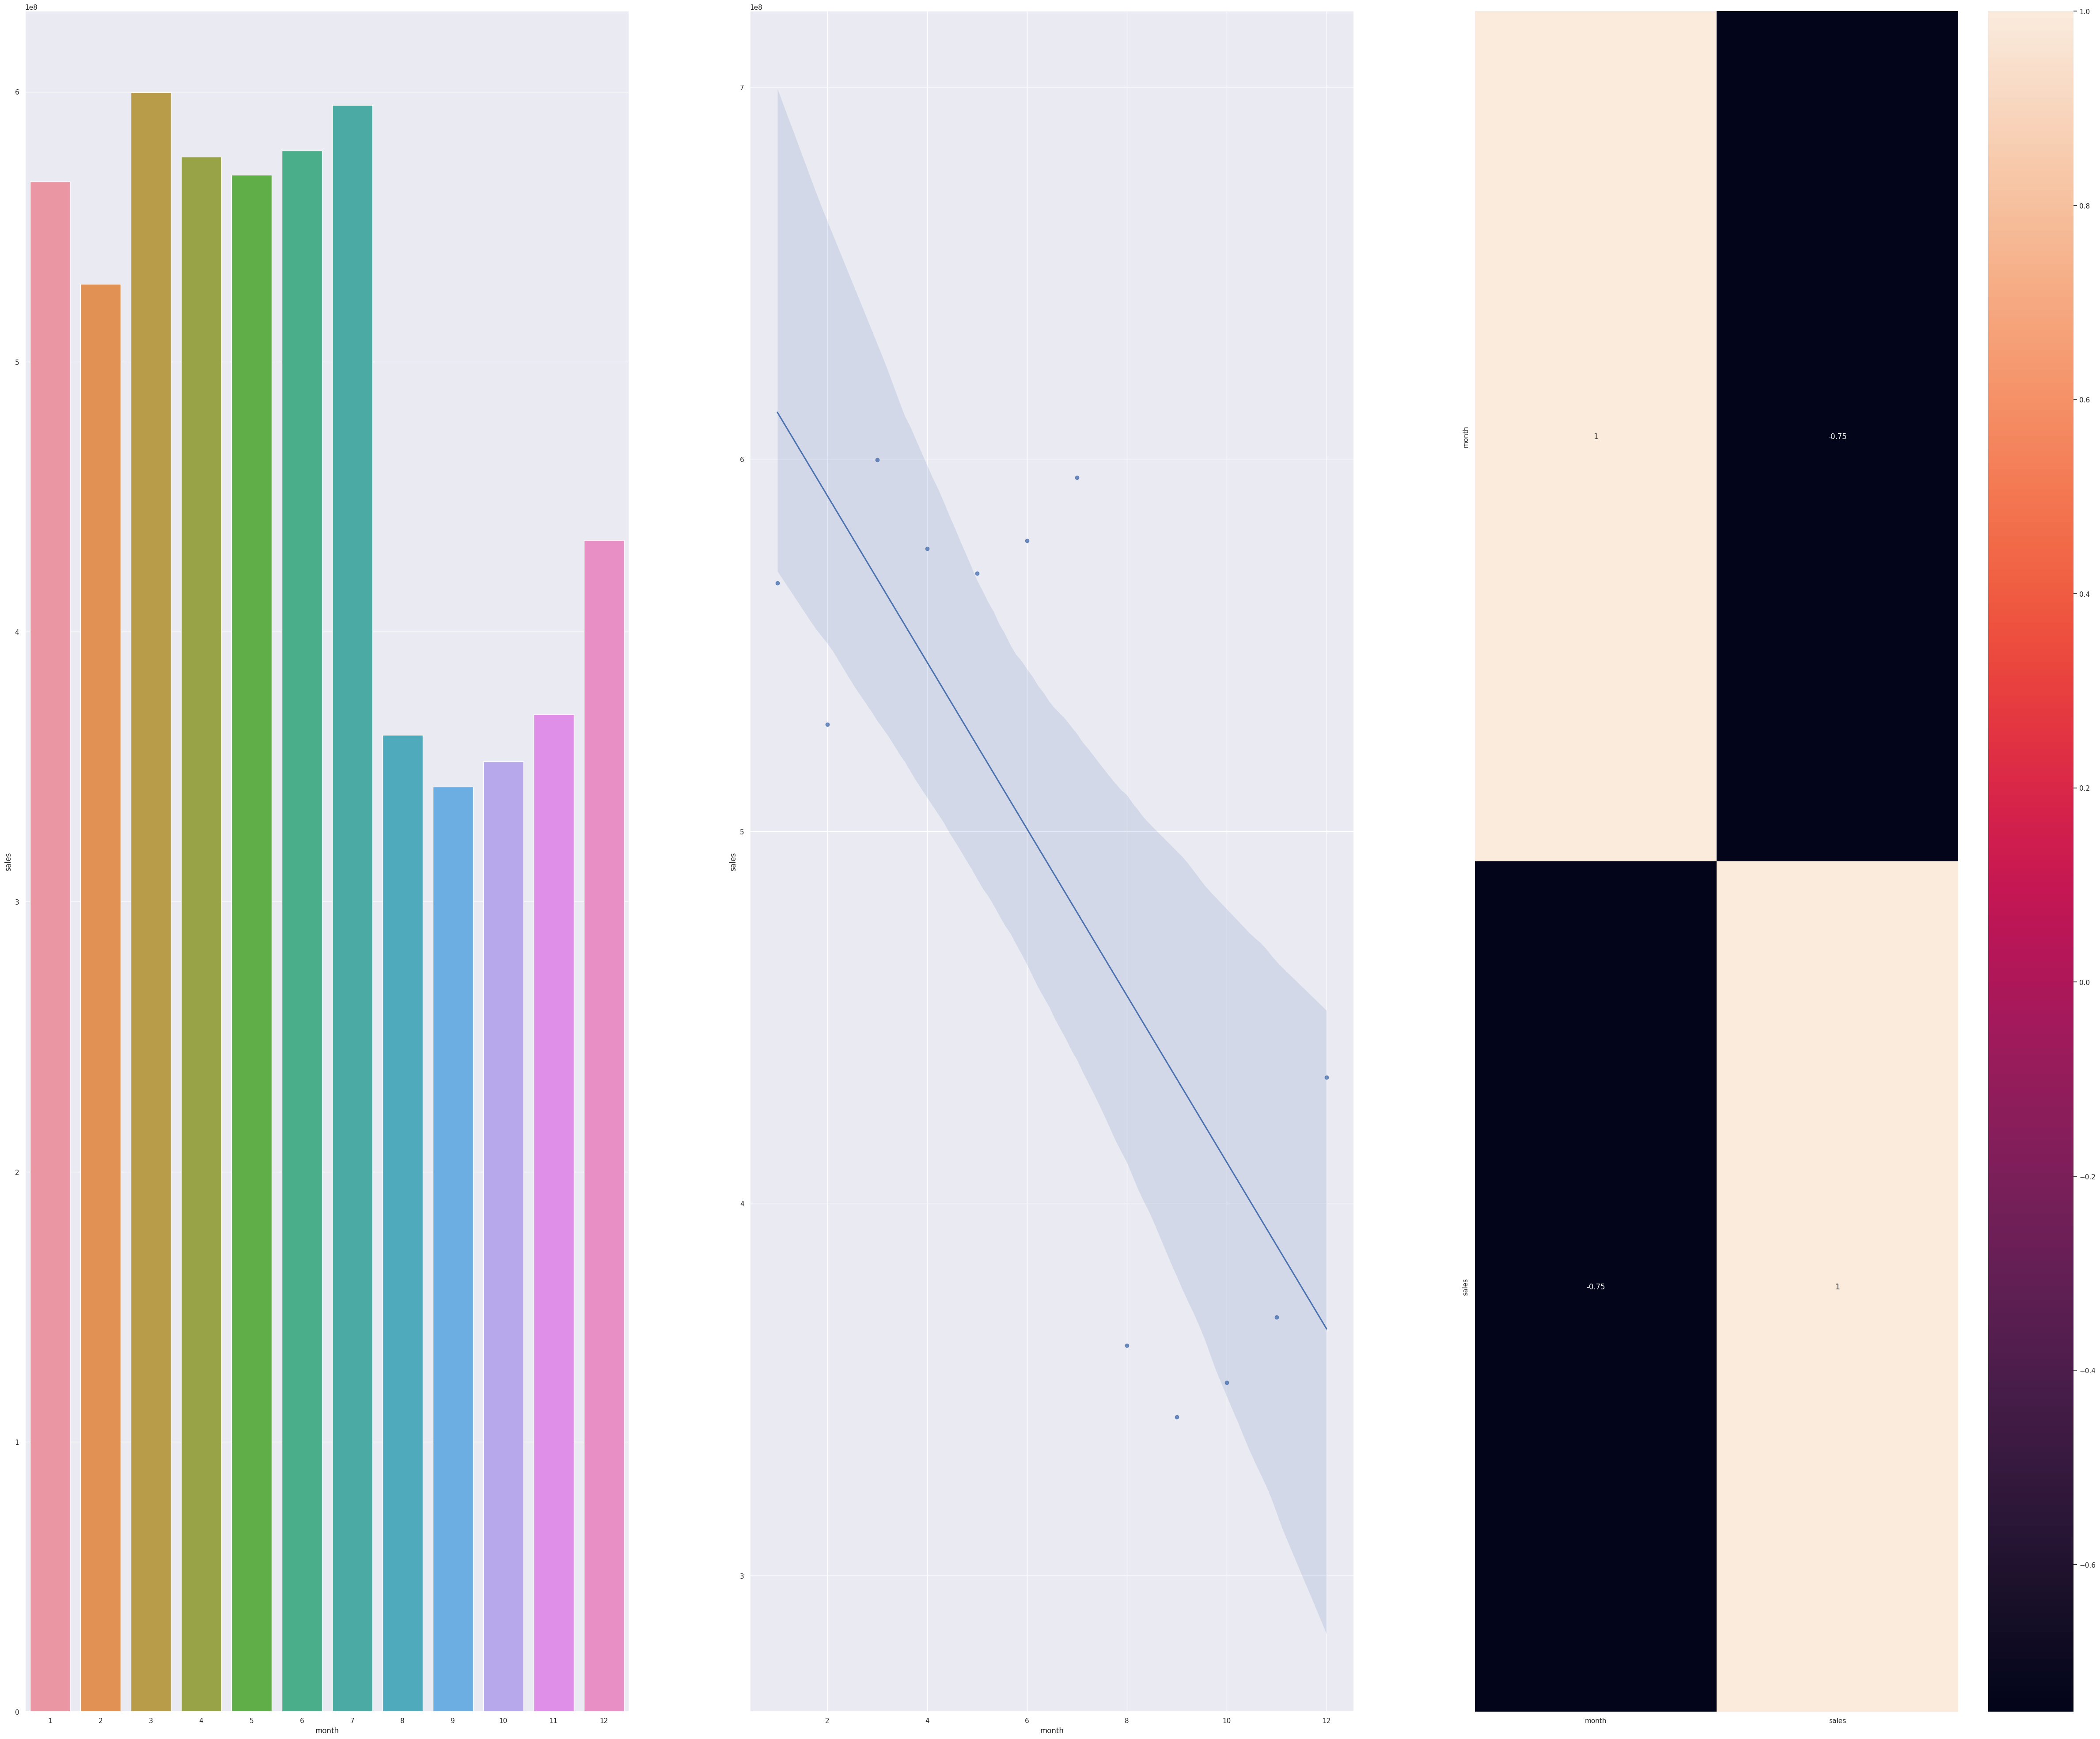

In [127]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H10** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeira** - lojas vendem mais depois do dia 10 de cada mês!

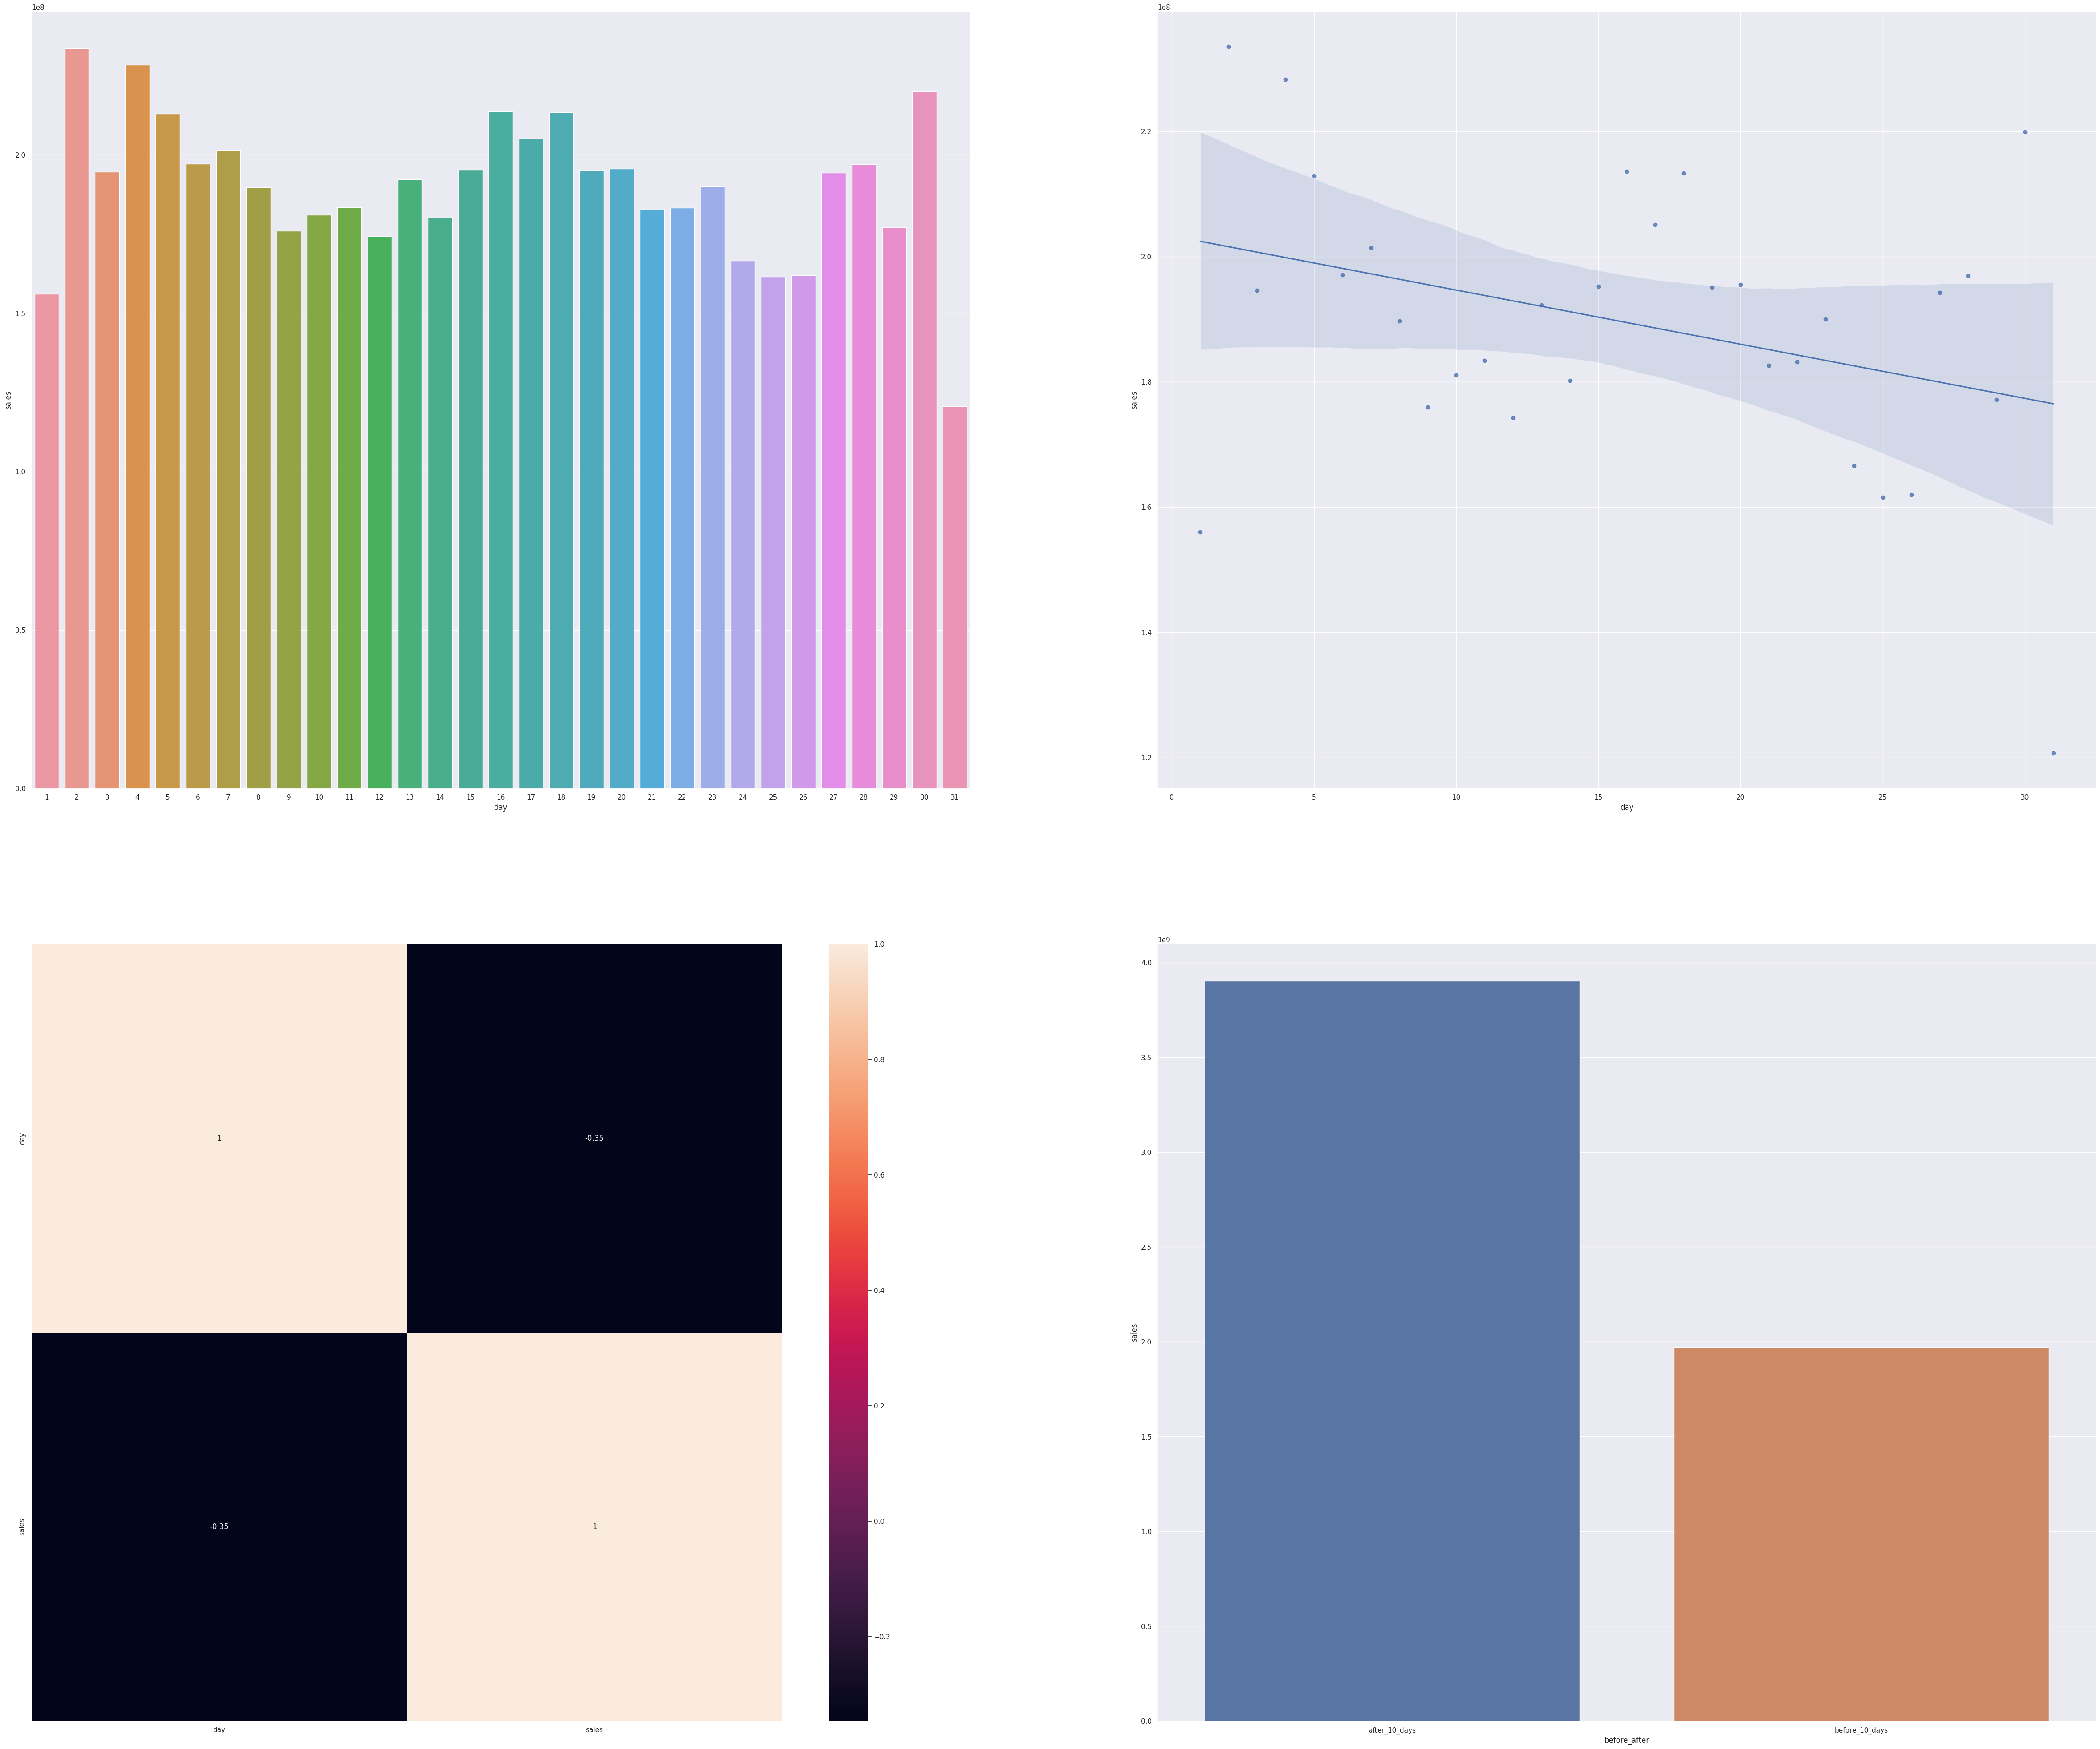

In [128]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

#### **H11** Lojas deveriam vender menos aos finais de semana.
**Verdadeira** - lojas vendem menos aos finais de semana.

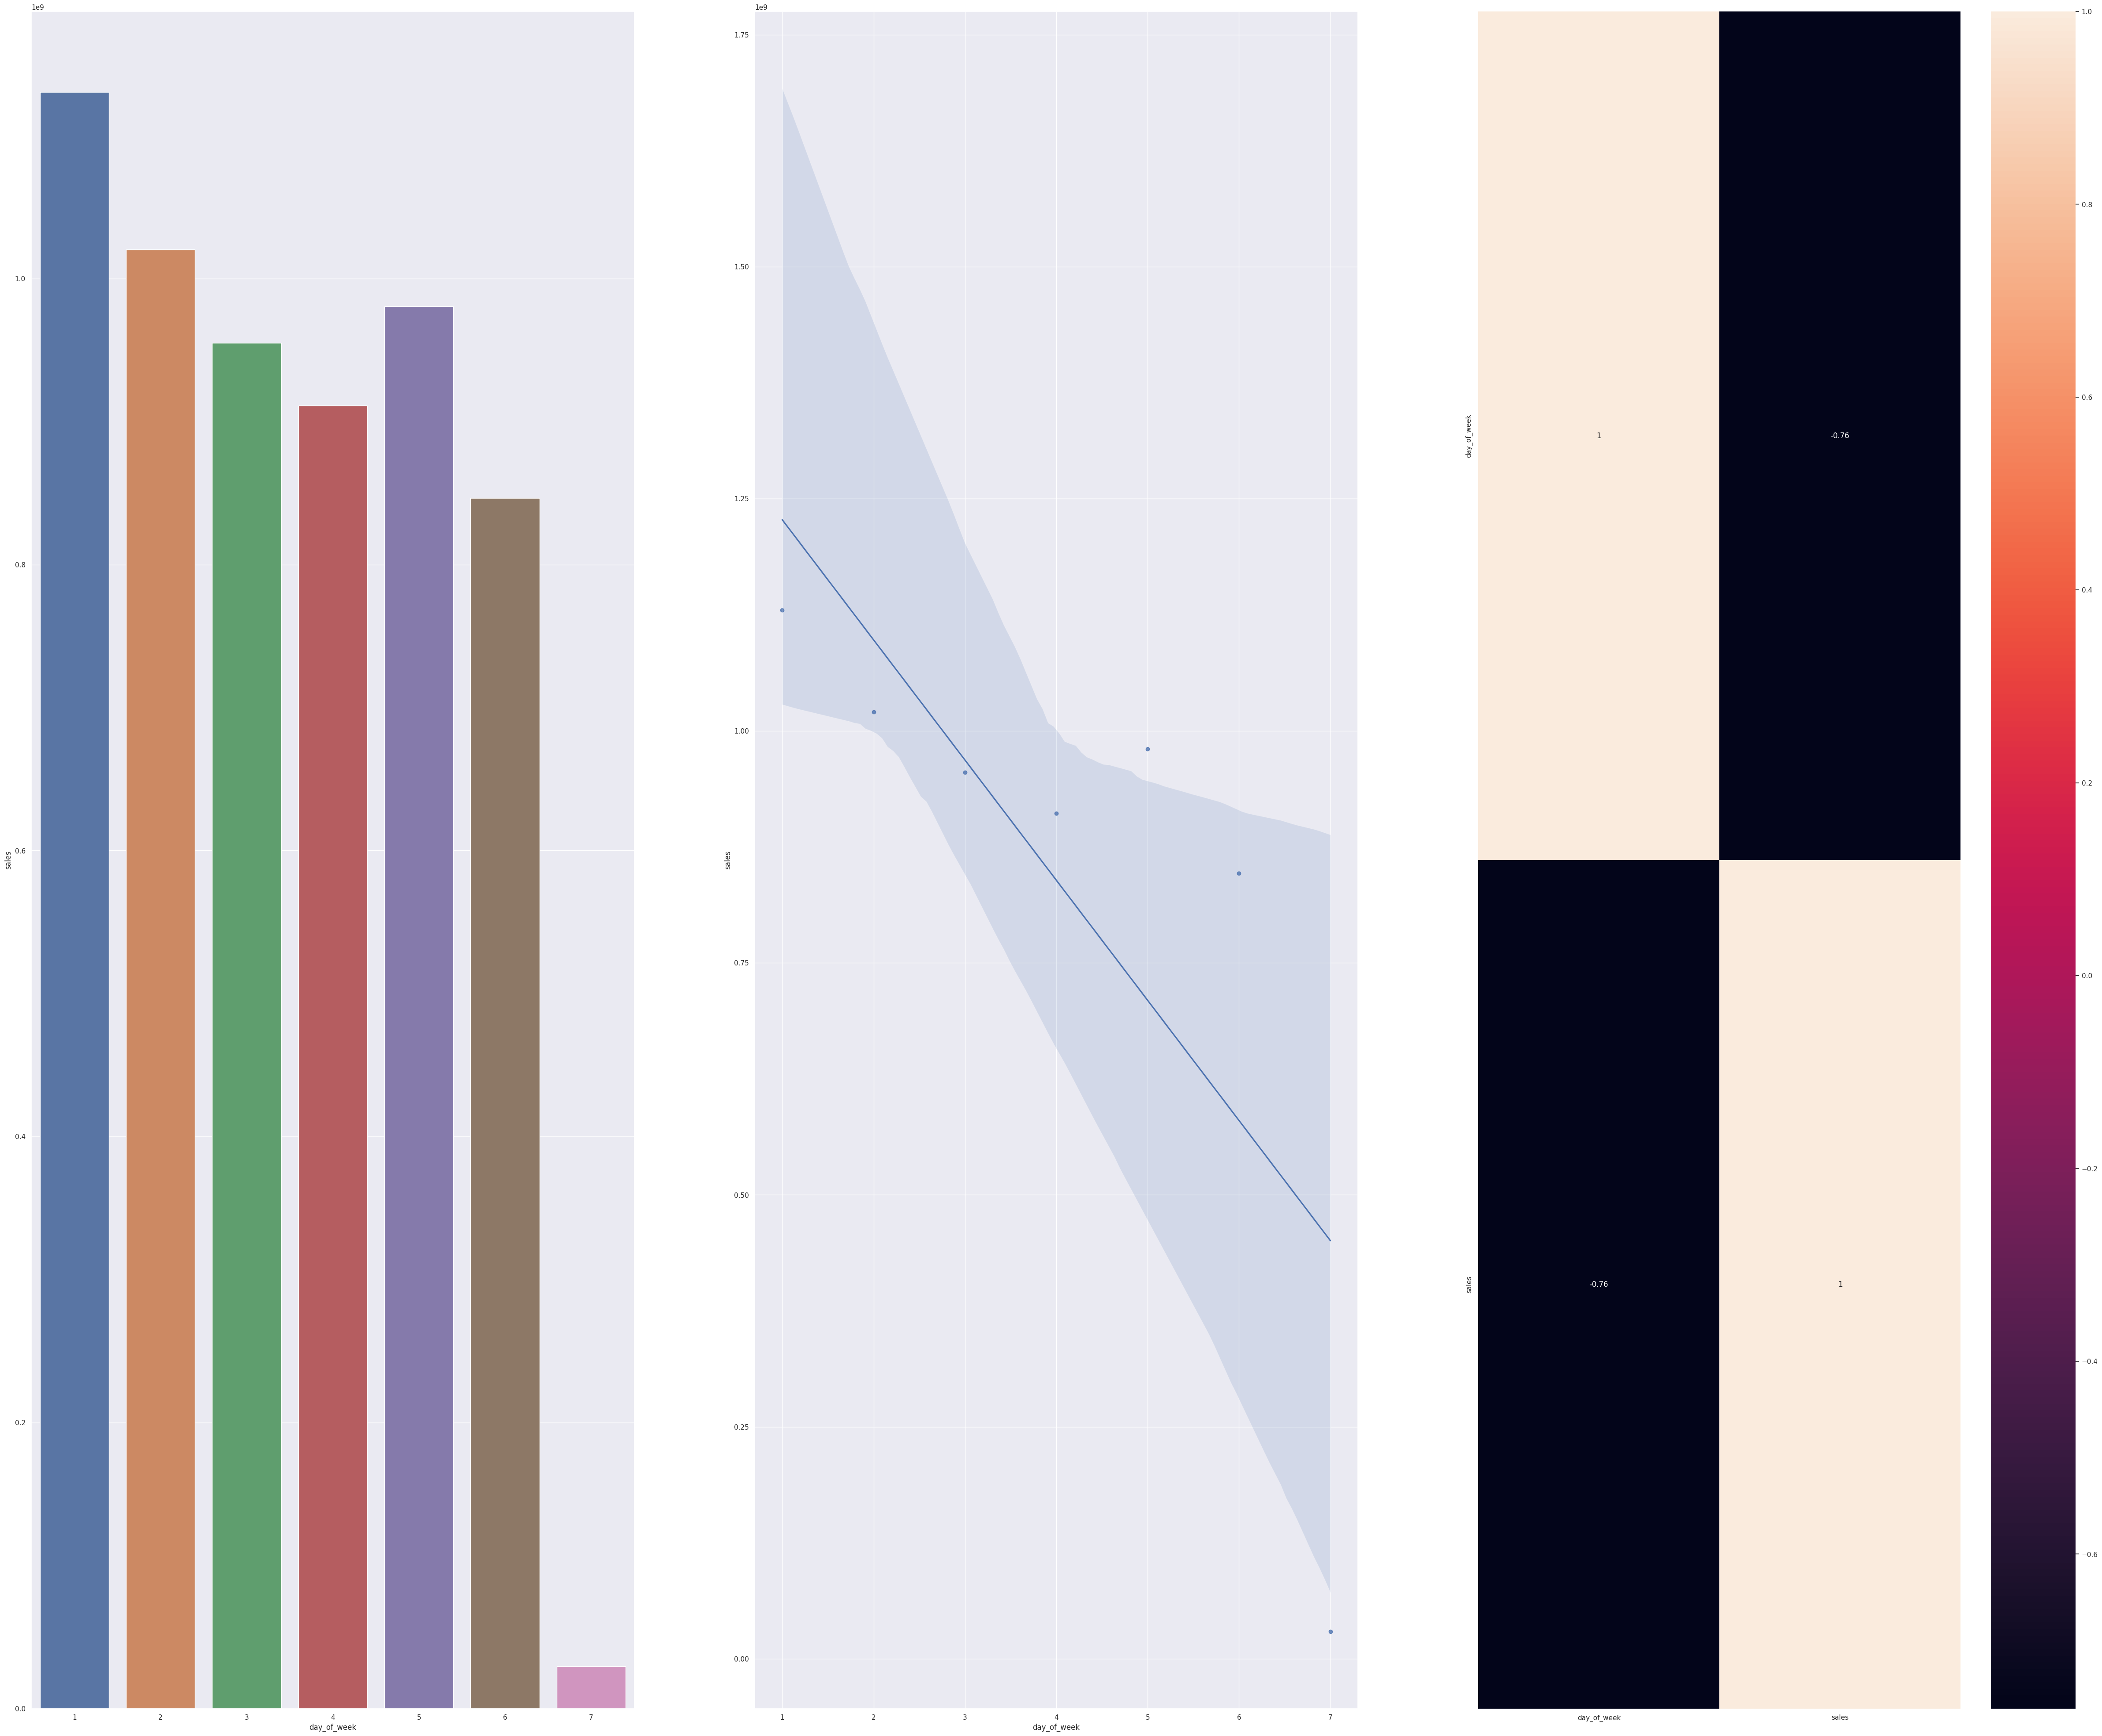

In [129]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H12** Lojas deveriam vender menos durante os feriados escolares
**Verdadeira** - lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto.

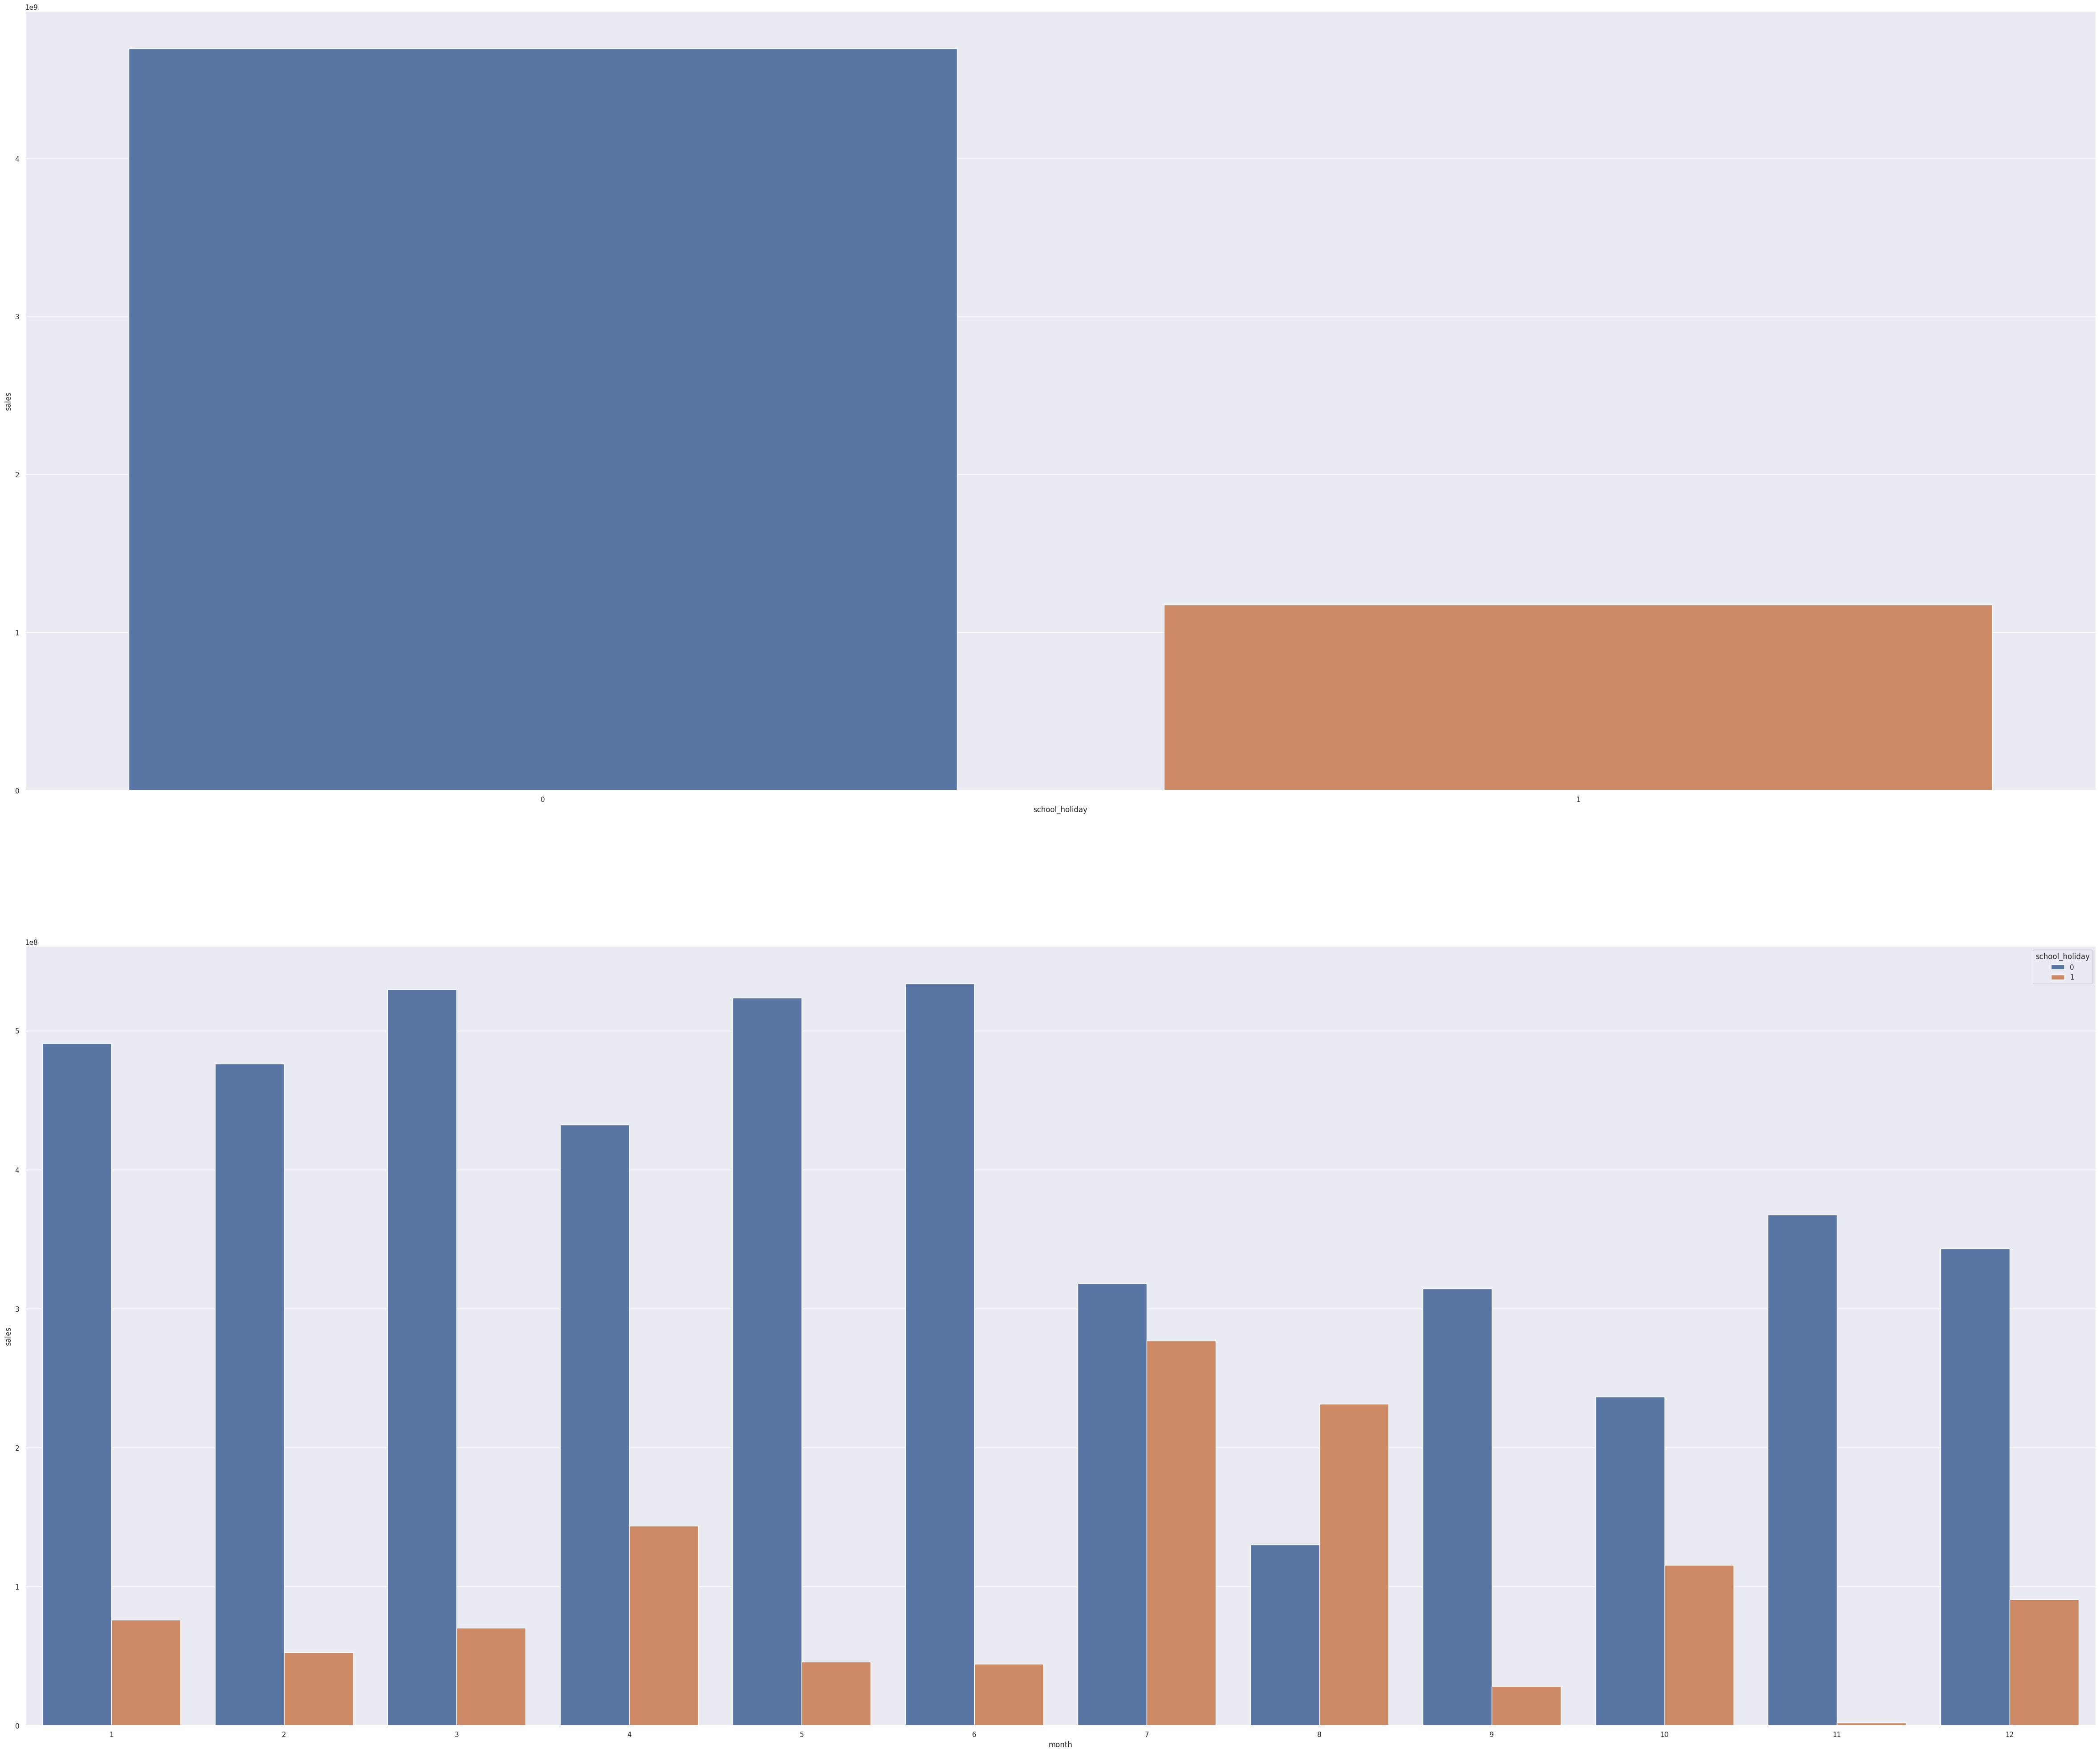

In [130]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.2 Resumo das Hipóteses

In [131]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

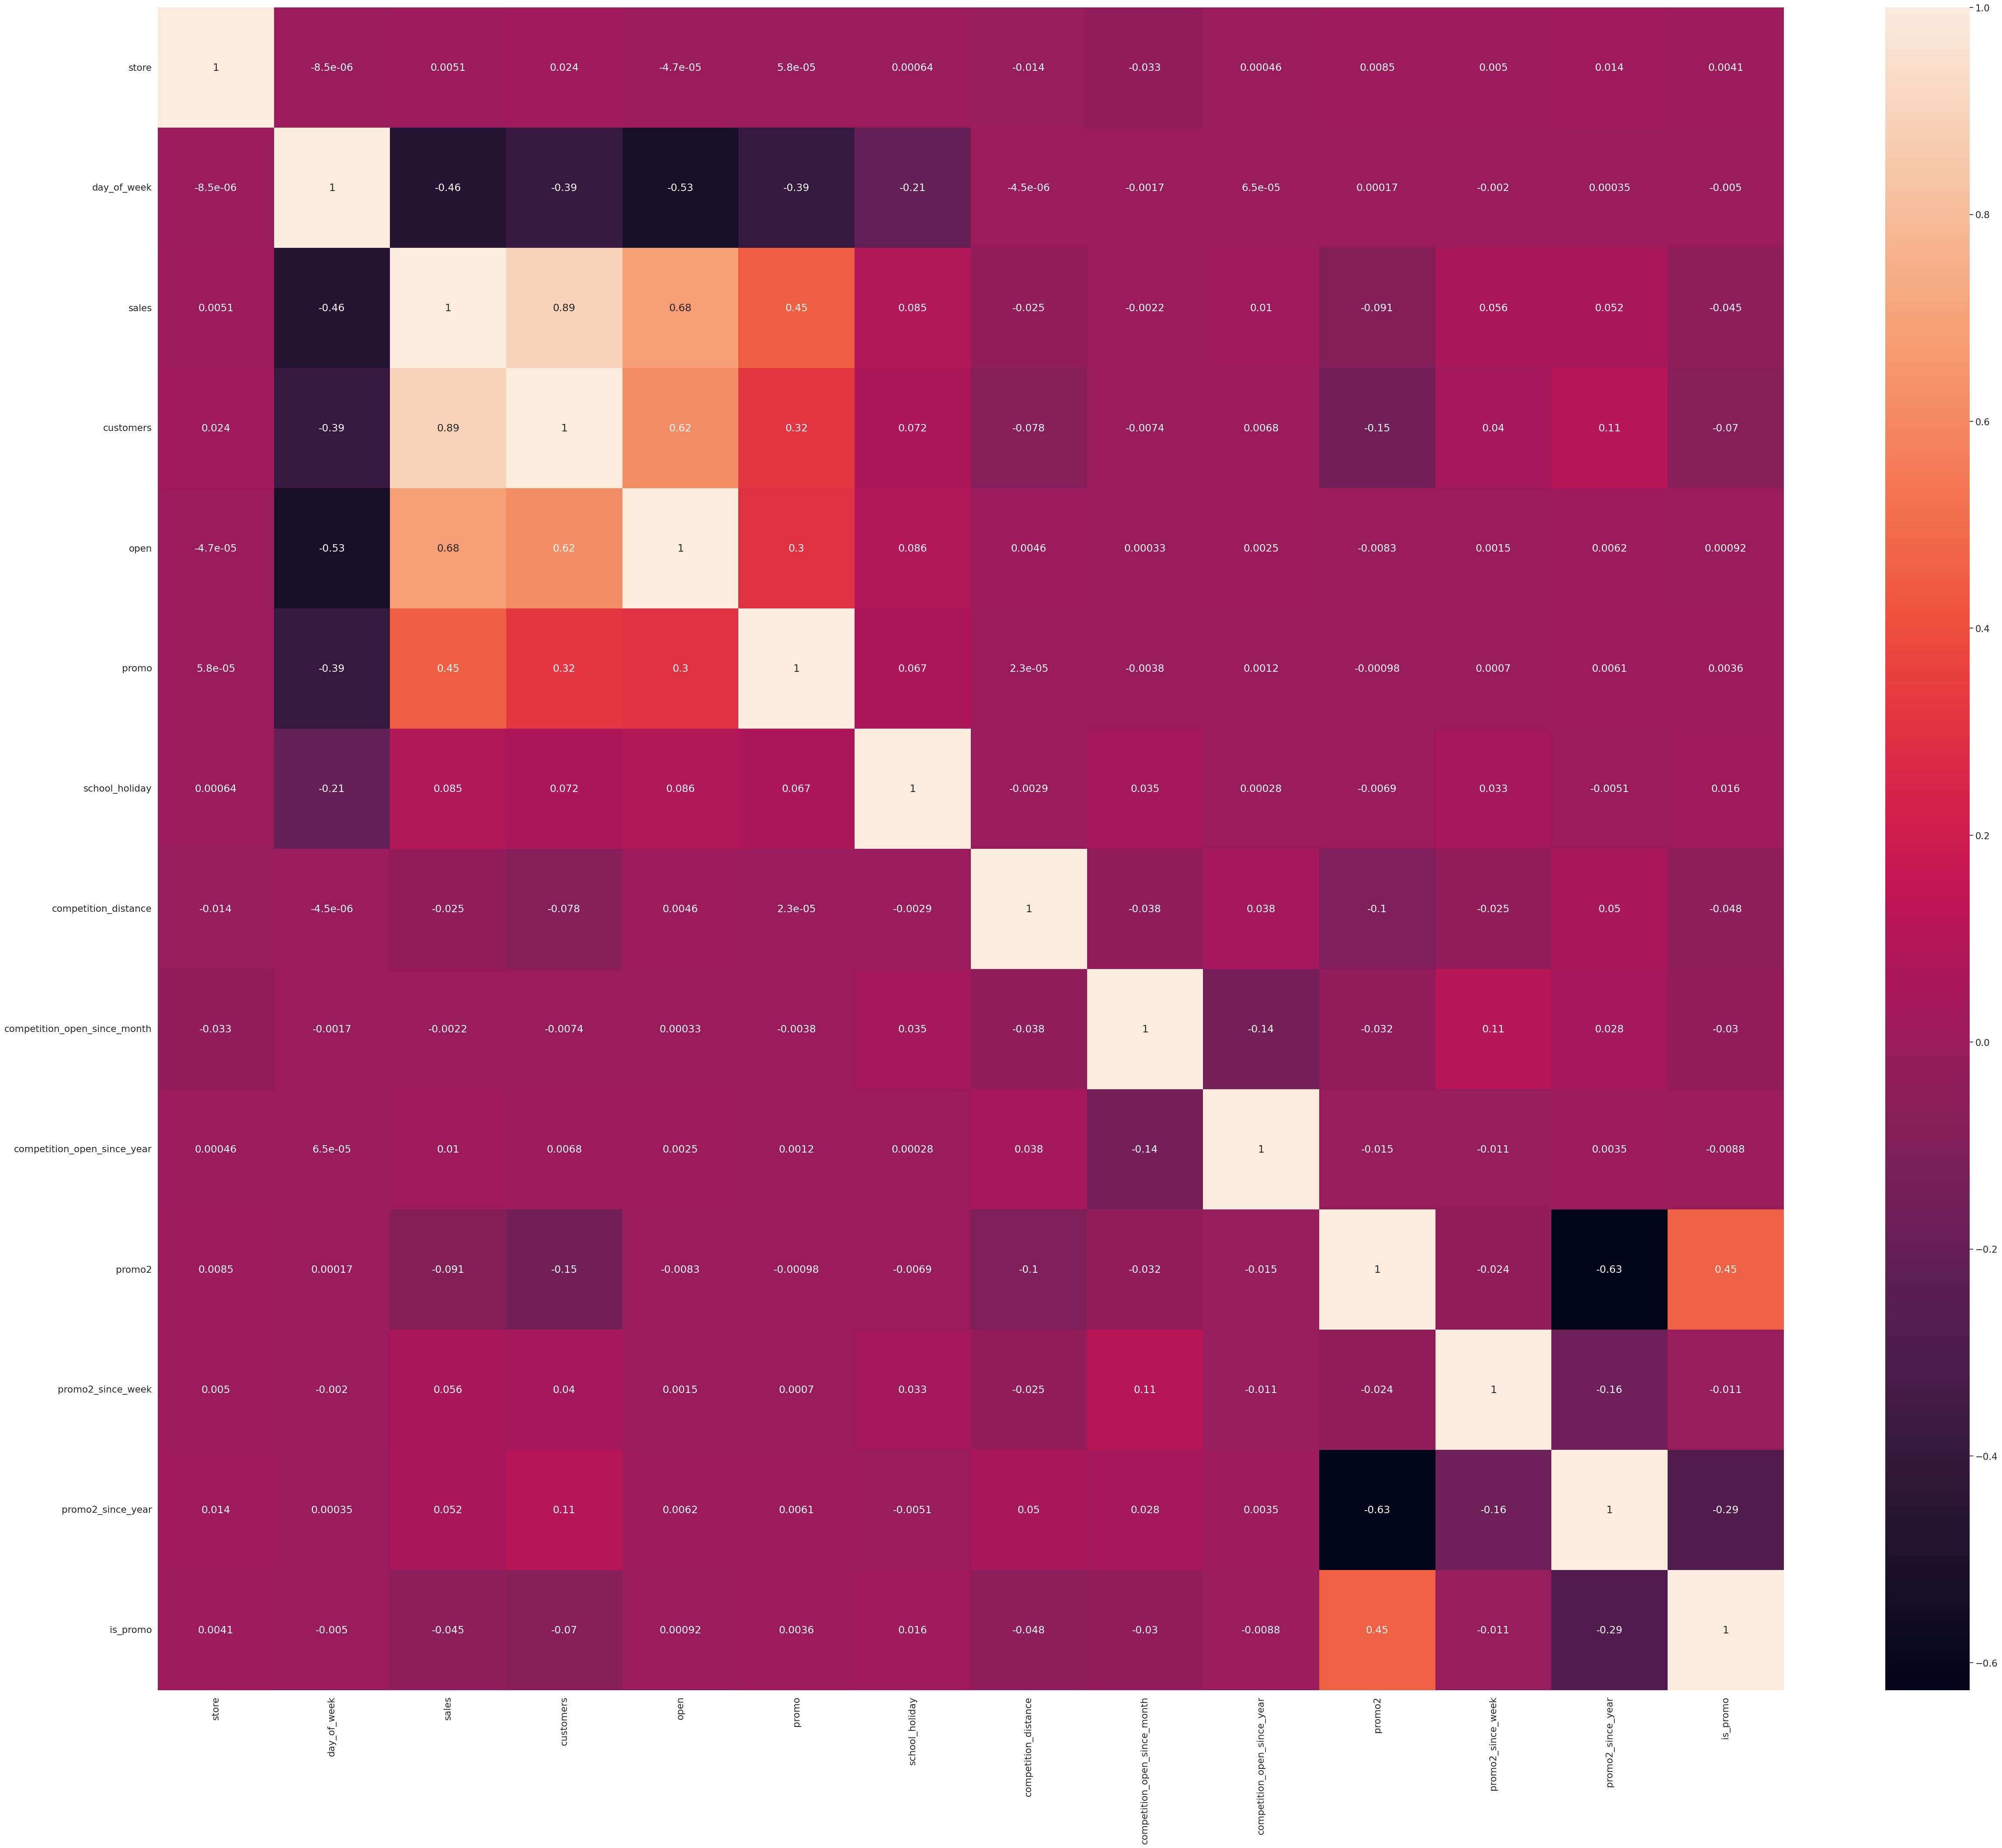

In [154]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );
sns.set(font_scale=1.8)


### 4.3.2 Categorical Attributes

In [133]:
a = df4.select_dtypes(include='object')

In [134]:
a.head()

state_holiday store_type assortment year_week
0   regular_day          c      basic   2015-30
1   regular_day          a      basic   2015-30
2   regular_day          a      basic   2015-30
3   regular_day          c   extended   2015-30
4   regular_day          a      basic   2015-30

In [135]:
a[(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a')]

state_holiday store_type assortment year_week
241499     christmas          a   extended   2014-51
241977     christmas          a   extended   2014-51
616339     christmas          a   extended   2013-51
616908     christmas          a   extended   2013-51

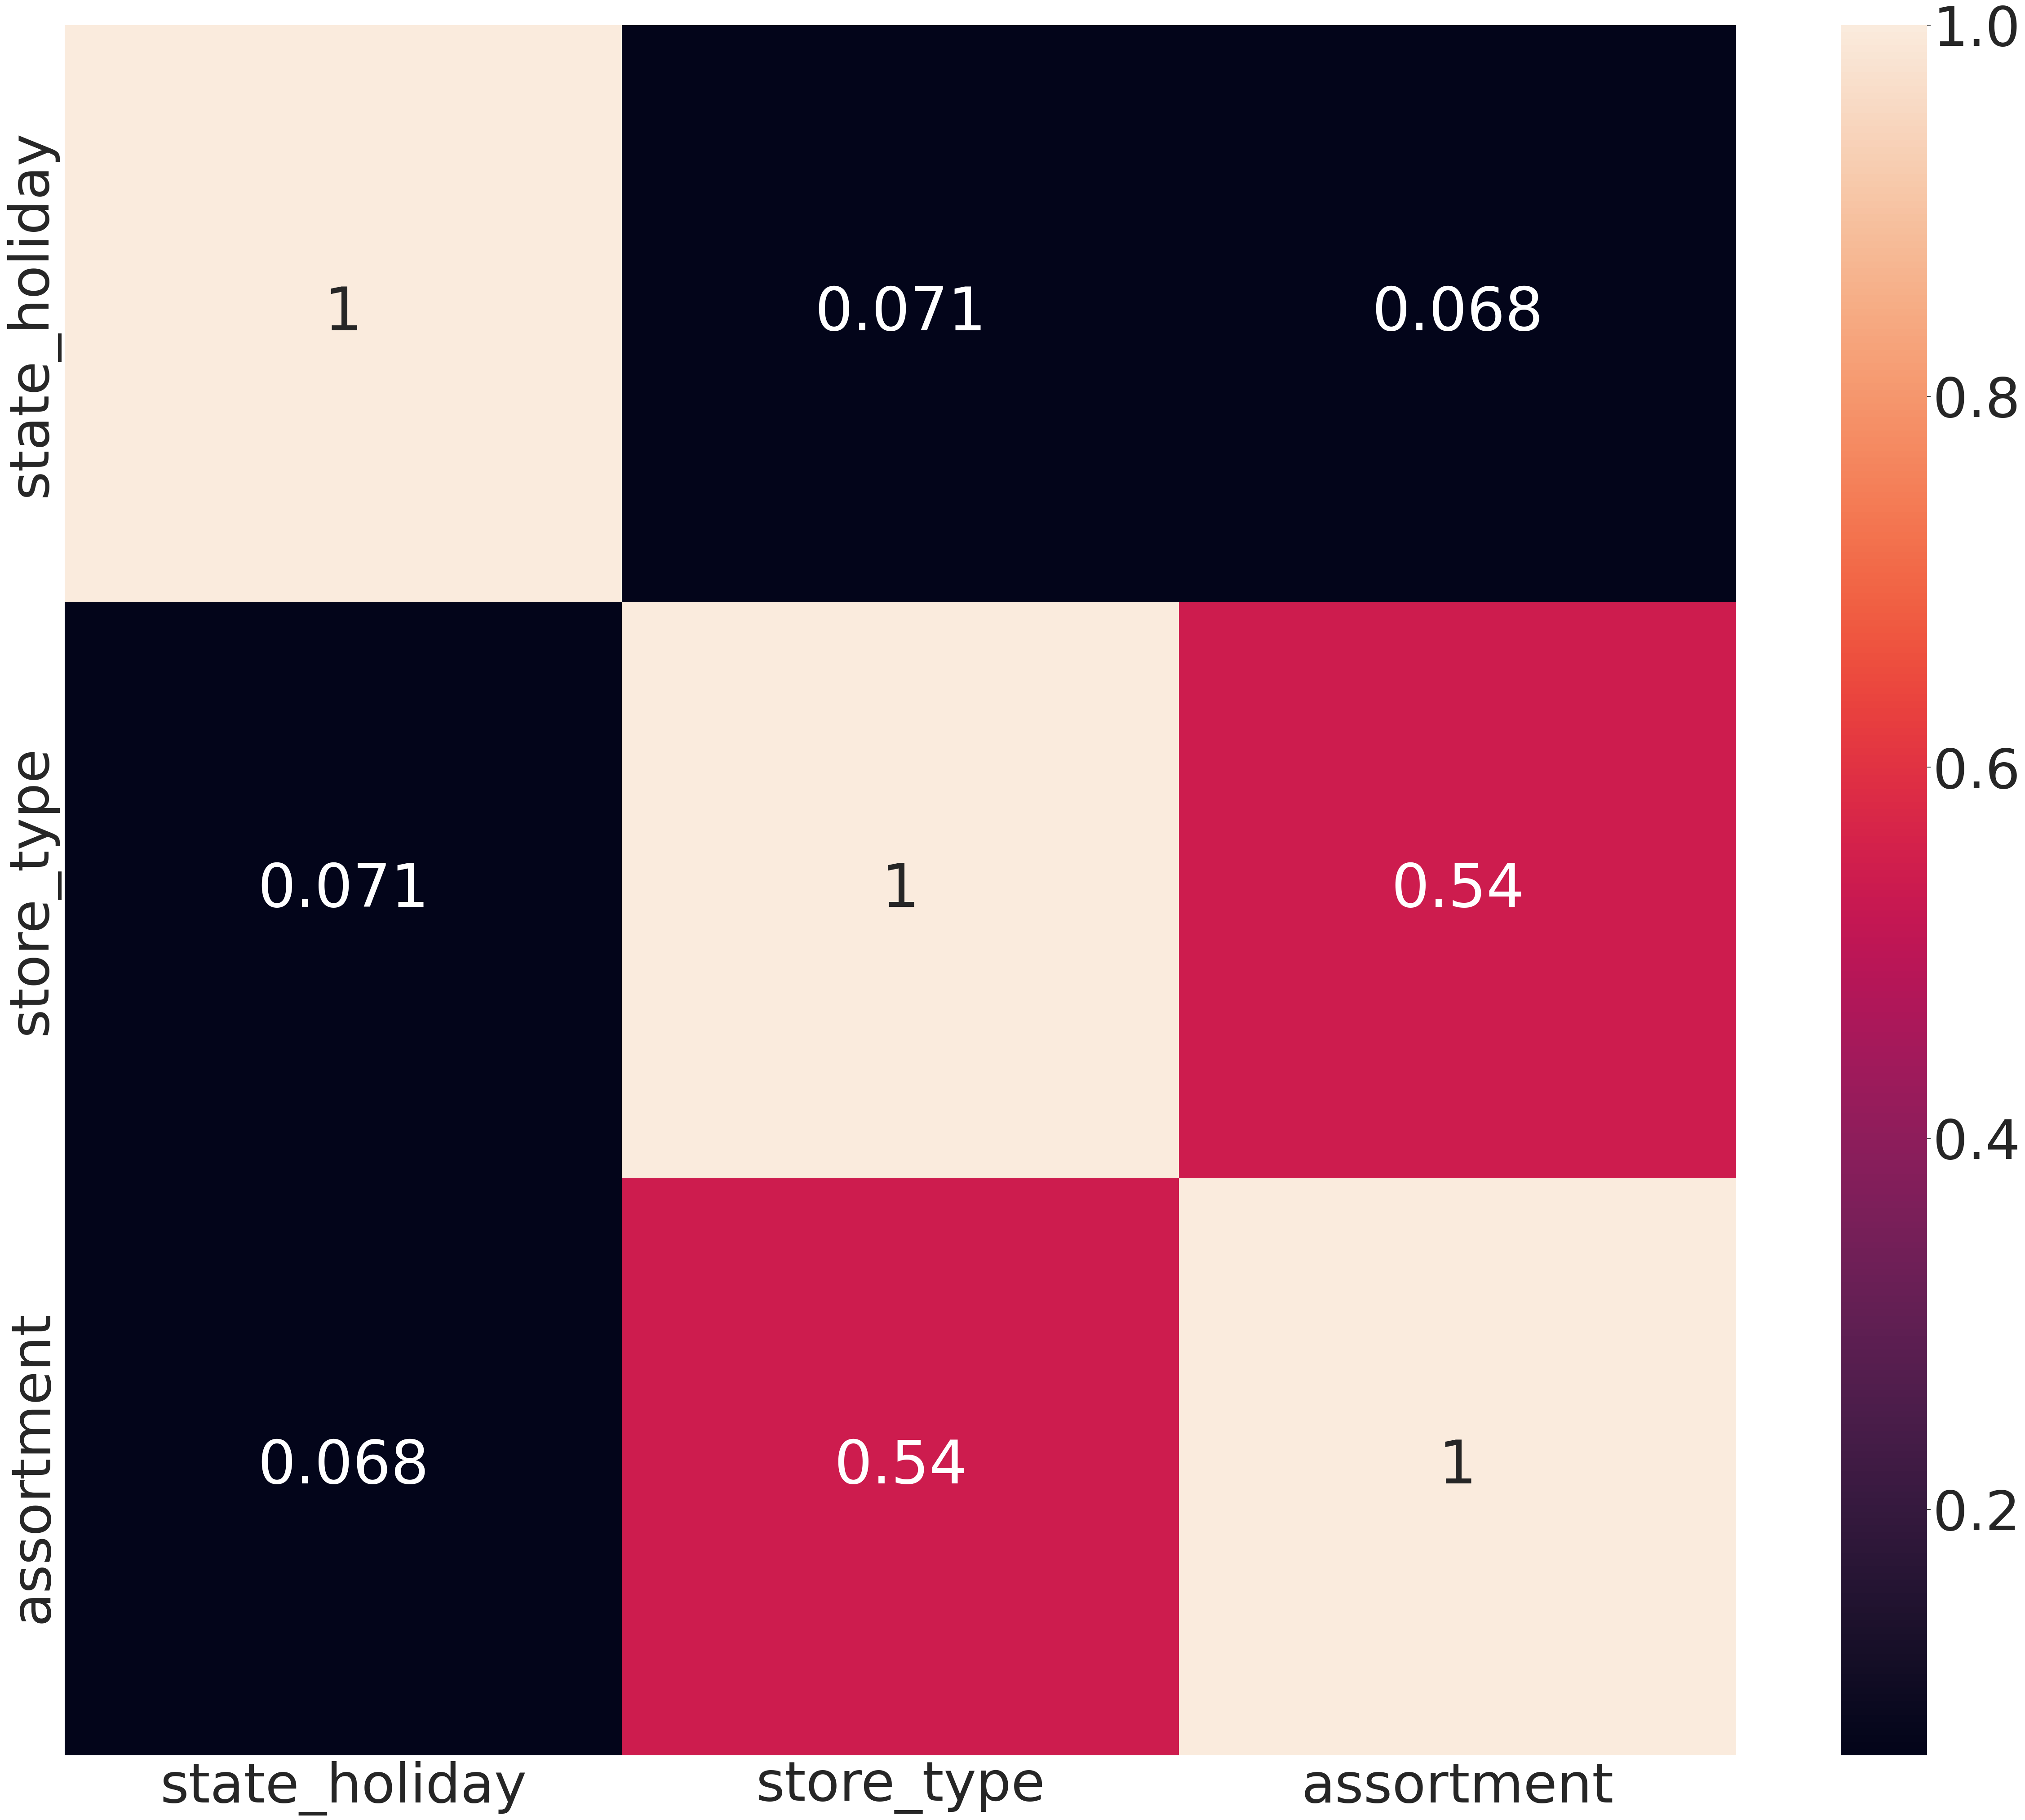

In [145]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramers_v( a['state_holiday'], a['state_holiday'] )
a2 = cramers_v( a['state_holiday'], a['store_type'] )
a3 = cramers_v( a['state_holiday'], a['assortment'] )
a4 = cramers_v( a['store_type'], a['state_holiday'] )
a5 = cramers_v( a['store_type'], a['store_type'] )
a6 = cramers_v( a['store_type'], a['assortment'] )
a7 = cramers_v( a['assortment'], a['state_holiday'] )
a8 = cramers_v( a['assortment'], a['store_type'] )
a9 = cramers_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9] })

d = d.set_index( d.columns )
sns.heatmap( d, annot=True )
sns.set(font_scale=5)